In [2]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import numpy as np
from scipy import signal
from scipy import io

# voytek lab tools
from neurodsp import spectral # for making PSD
from neurodsp import filt # for filtering
from neurodsp import sim # for simulating data

# fooof!
from fooof import FOOOF

# cycle-by-cycle
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params

# plotting stuff
import seaborn as sns # not necessary but I like seaborn
sns.set_style('whitegrid')

import matplotlib
import matplotlib.pyplot as plt

# plot settings
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (20,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Here we're just going to start by simulating sine waves and looking at the FFT of those

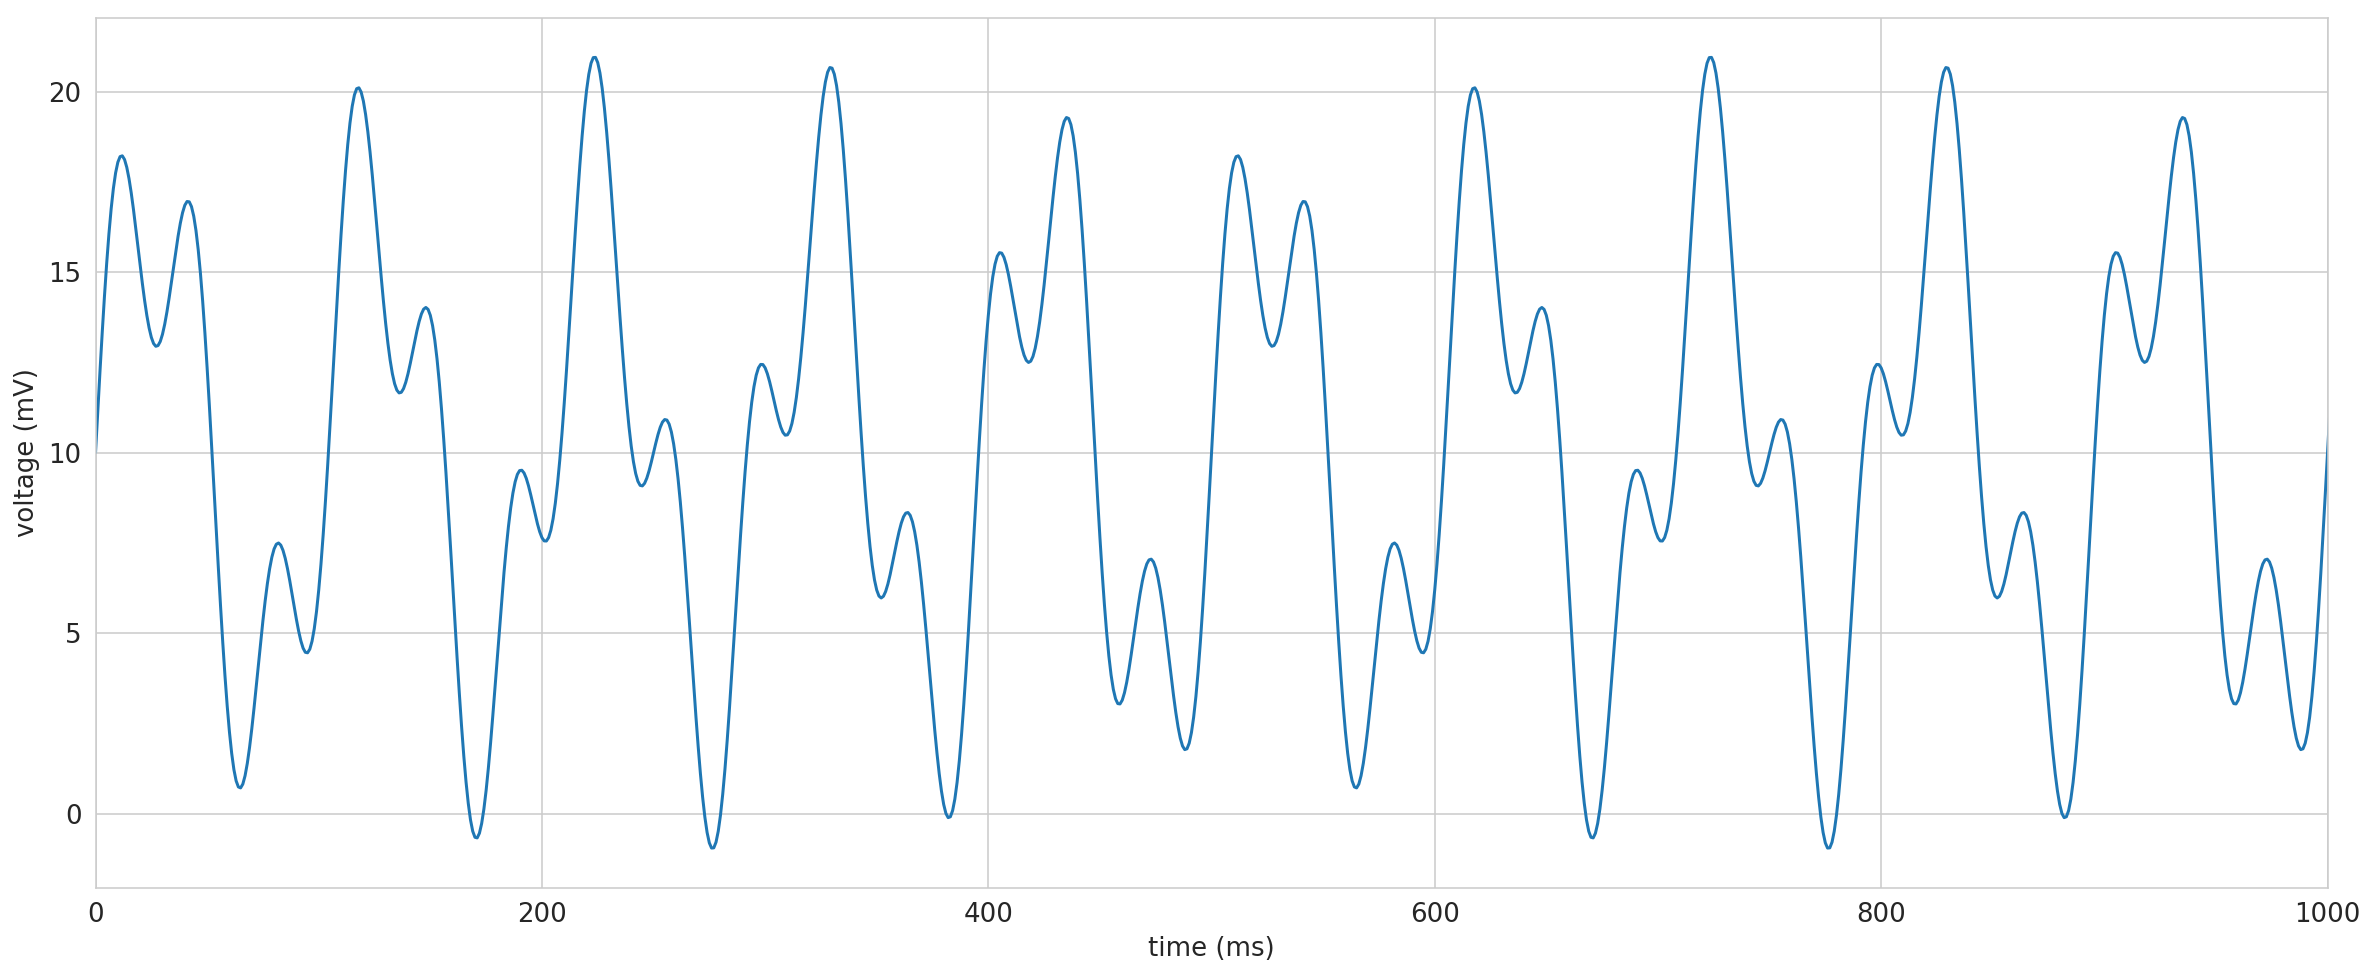

In [4]:
# define a function to create a sine wave
def sine_func(fs, freq, amp, time):
    samples = fs*time
    time = np.arange(samples)
    voltage = amp * np.sin(2 * np.pi * freq * time / fs)
    
    return time, voltage

fs = 1000 # sampling rate

freq = 10 # in Hz
amp = 7 # in arbitrary units (au)
duration = 10. # in seconds

time, sine = sine_func(fs, freq, amp, duration)
sine = sine + 10 # add a DC offset

# add another sine to the first
freq, amp, duration = 28, 4, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)

# plot some of the time series data
plt.plot(time, sine)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.xlim((0,1000)) # just plot the first second
plt.show()

### Check out the funky patterns that start to emerge from just _two_ sine waves overlapped!

### Let's look at the pwoer spectrum now

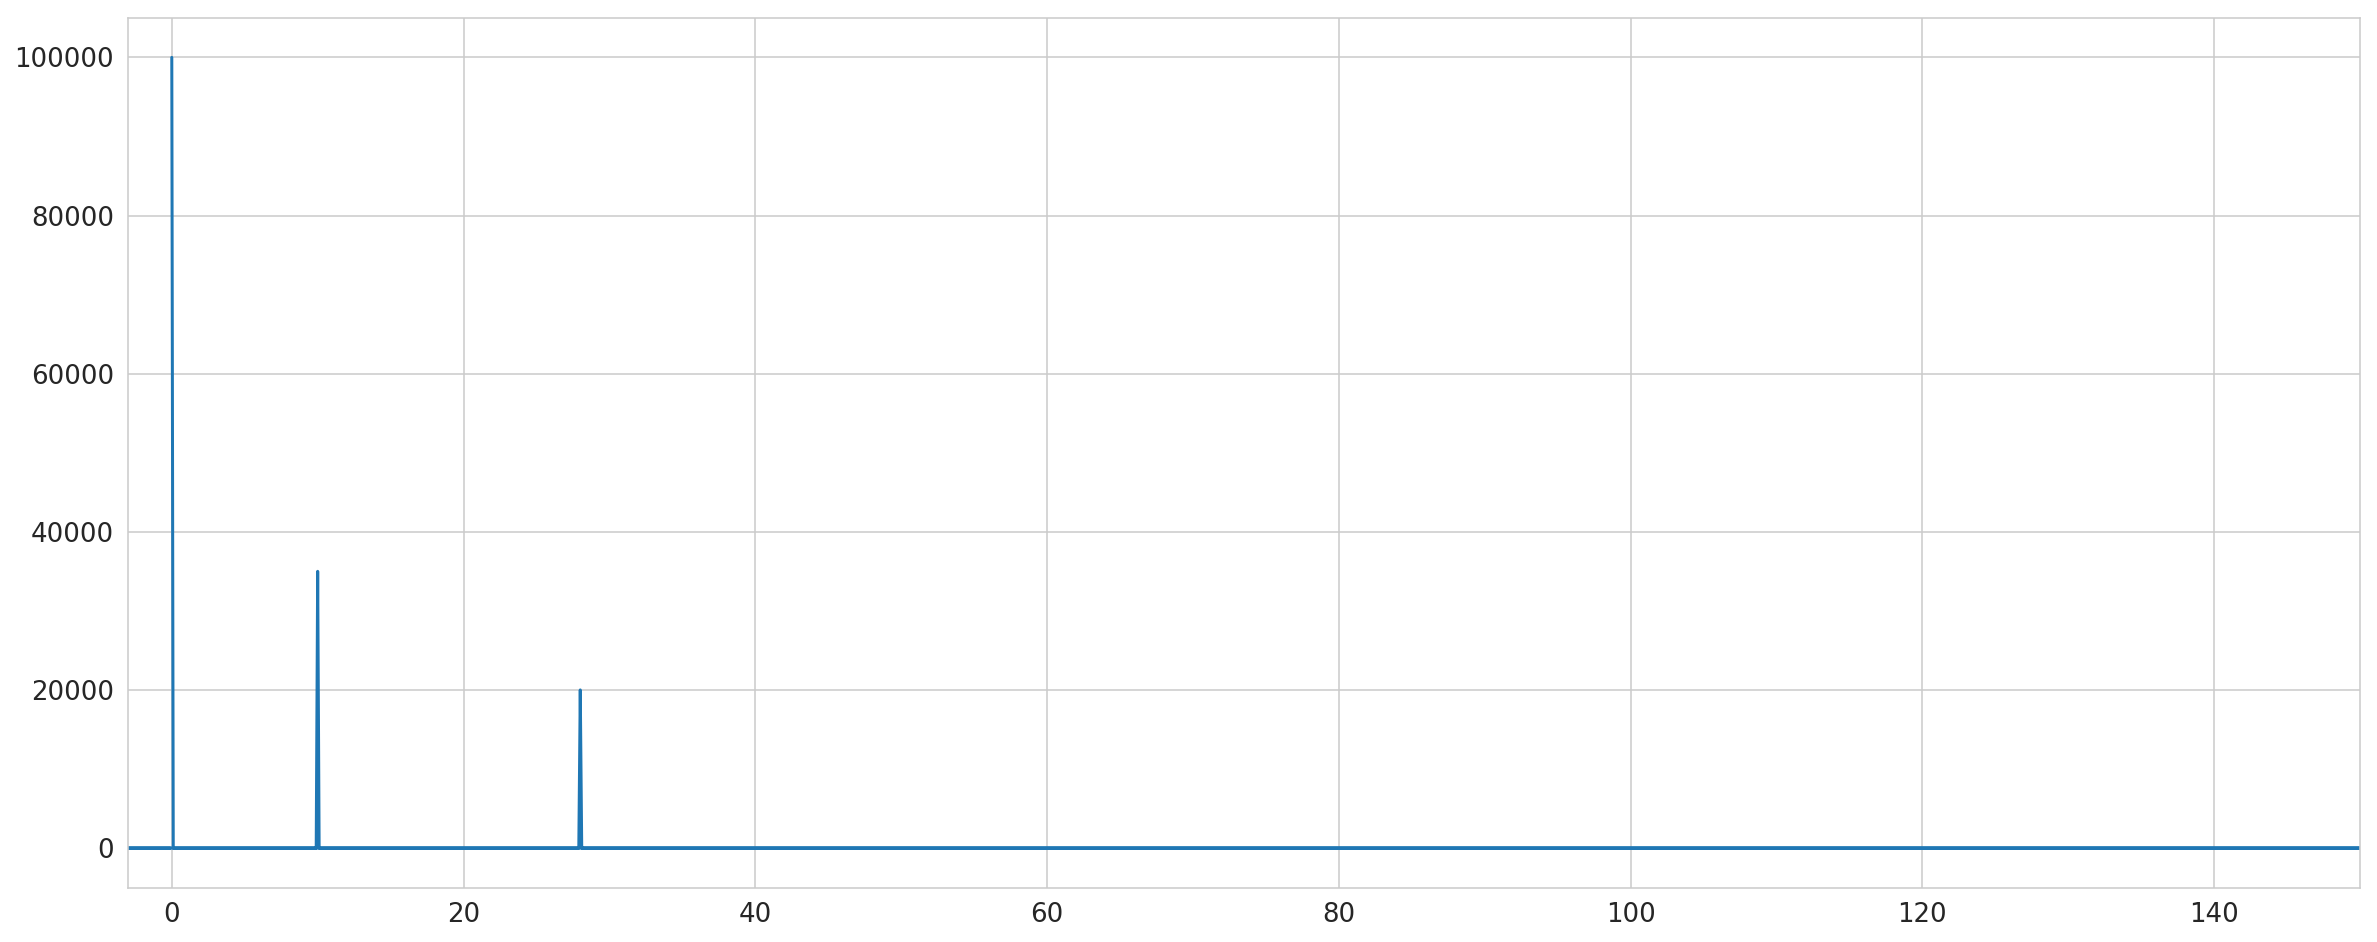

In [6]:
sp = np.abs(np.fft.fft(sine)) # get the power spectrum of the simulated data
freq = np.fft.fftfreq(sine.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((-3, 150))
plt.show()

### We see a lot of power at 0 Hz, which equals the DC offset we added. We also see power at both 10 and 28 Hz, which is good, because that's all our signal is!

### Now we'll add more sine waves and see what happens.

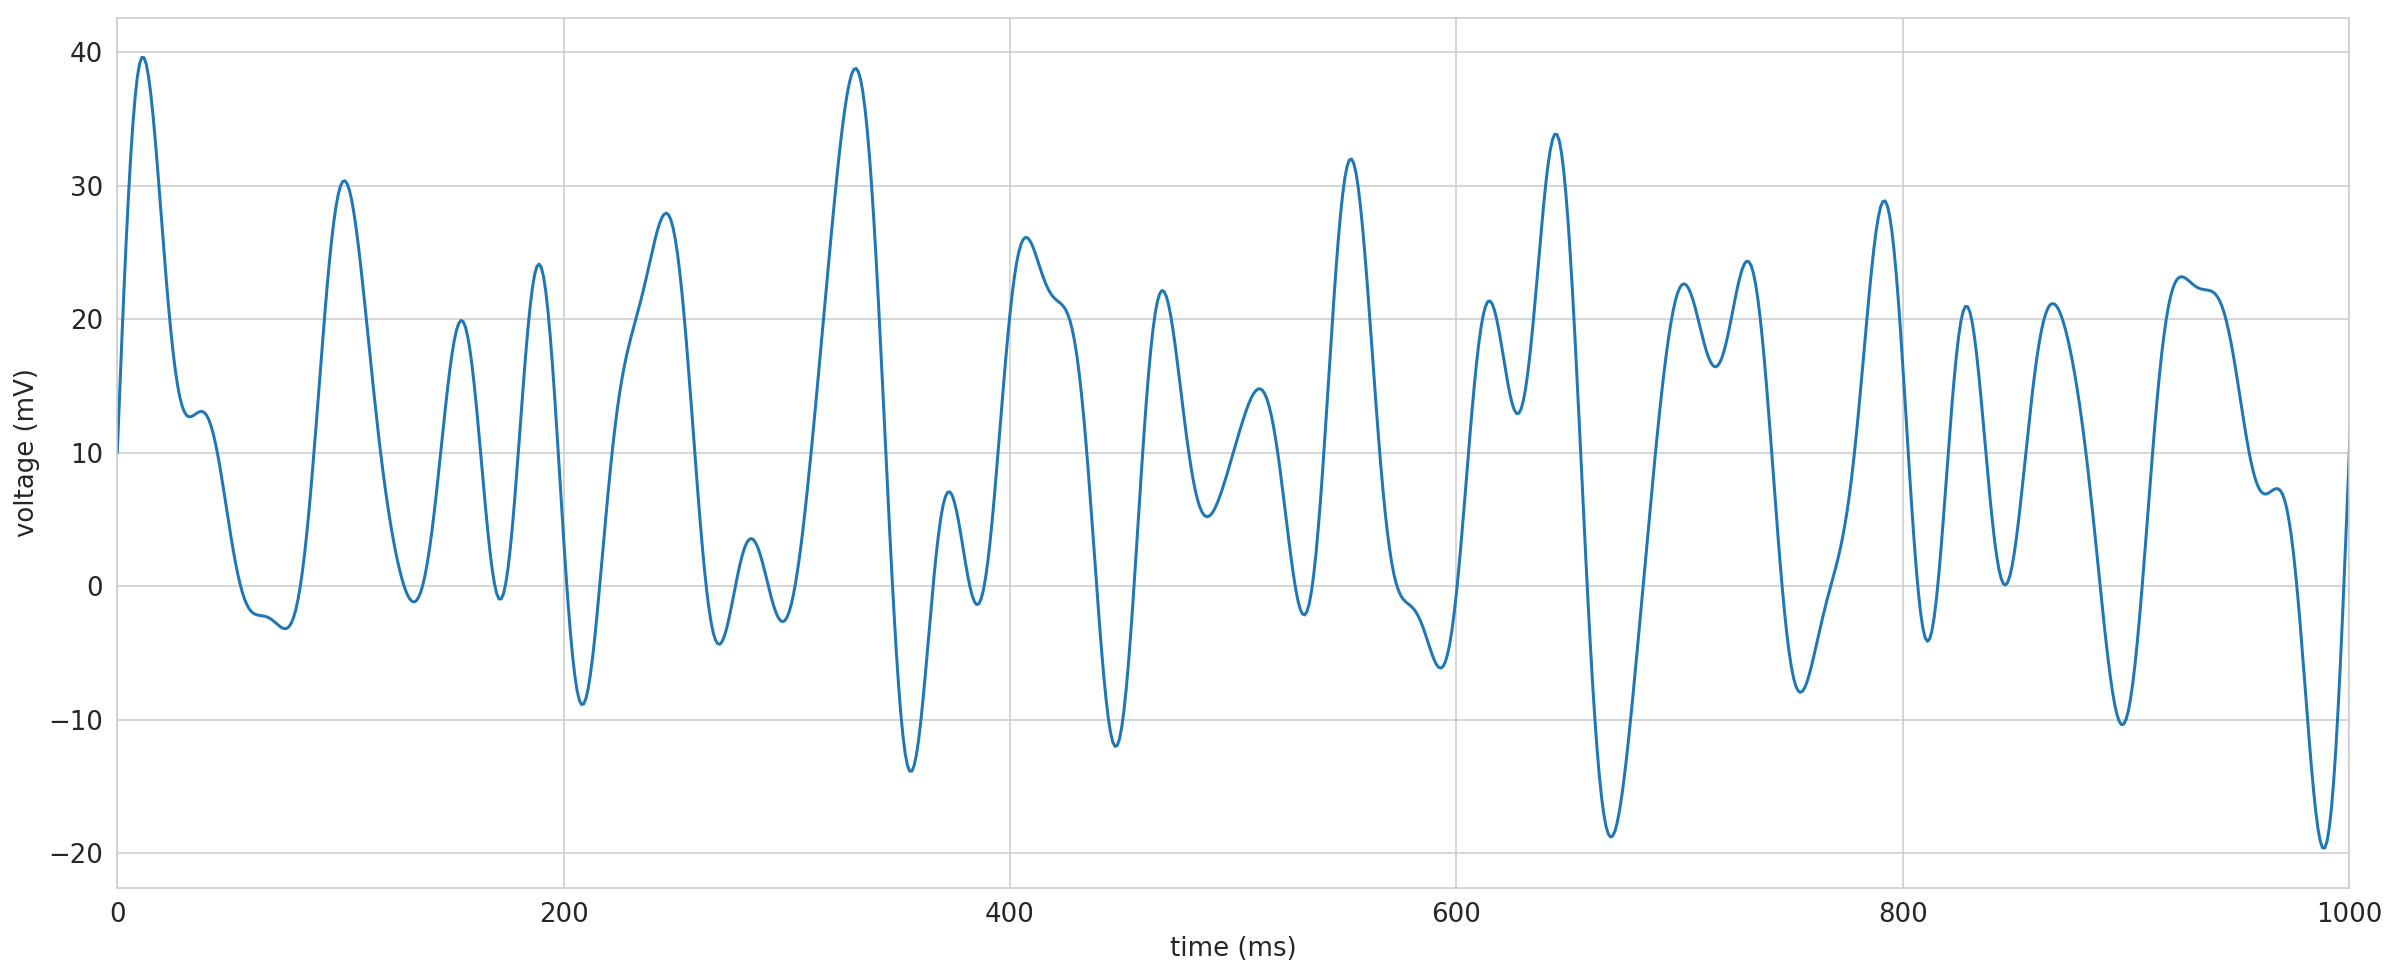

In [8]:
## add some more sine waves!
freq, amp, duration = 13, 6, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)
freq, amp, duration = 22, 4.5, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)
freq, amp, duration = 33, 2, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)

# plot some of the time series data
plt.plot(time, sine)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.xlim((0,1000)) # just plot the first second
plt.show()

### Now it starts to look pretty wild! Pretty "complex" looking, but from the FFT we'll see it's still pretty "simple".

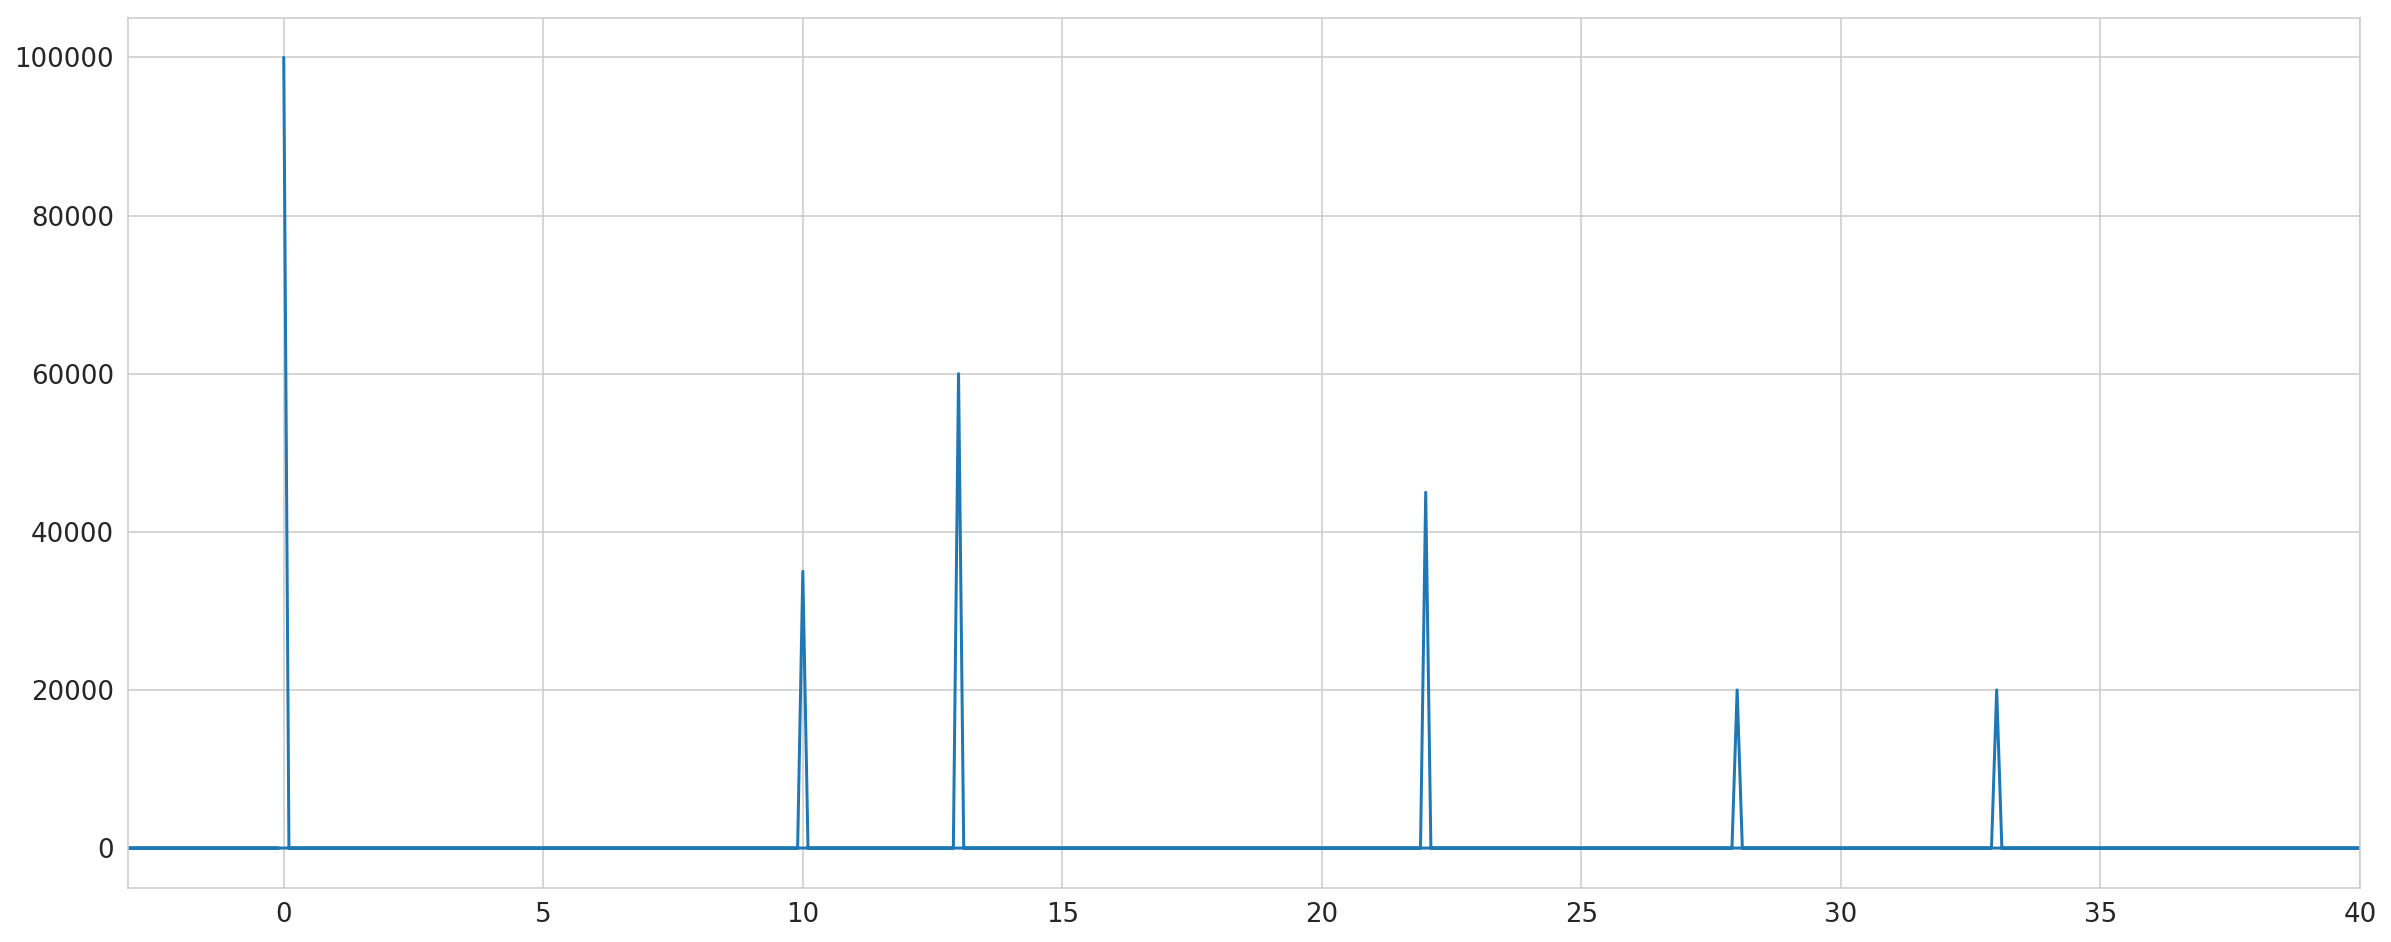

In [10]:
sp = np.abs(np.fft.fft(sine)) # get the power spectrum of the simulated data
freq = np.fft.fftfreq(sine.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((-3, 40))
plt.show()

### There's only power in the exact frequencies we added.

## Now we're going to actually load in real neural data and play with that

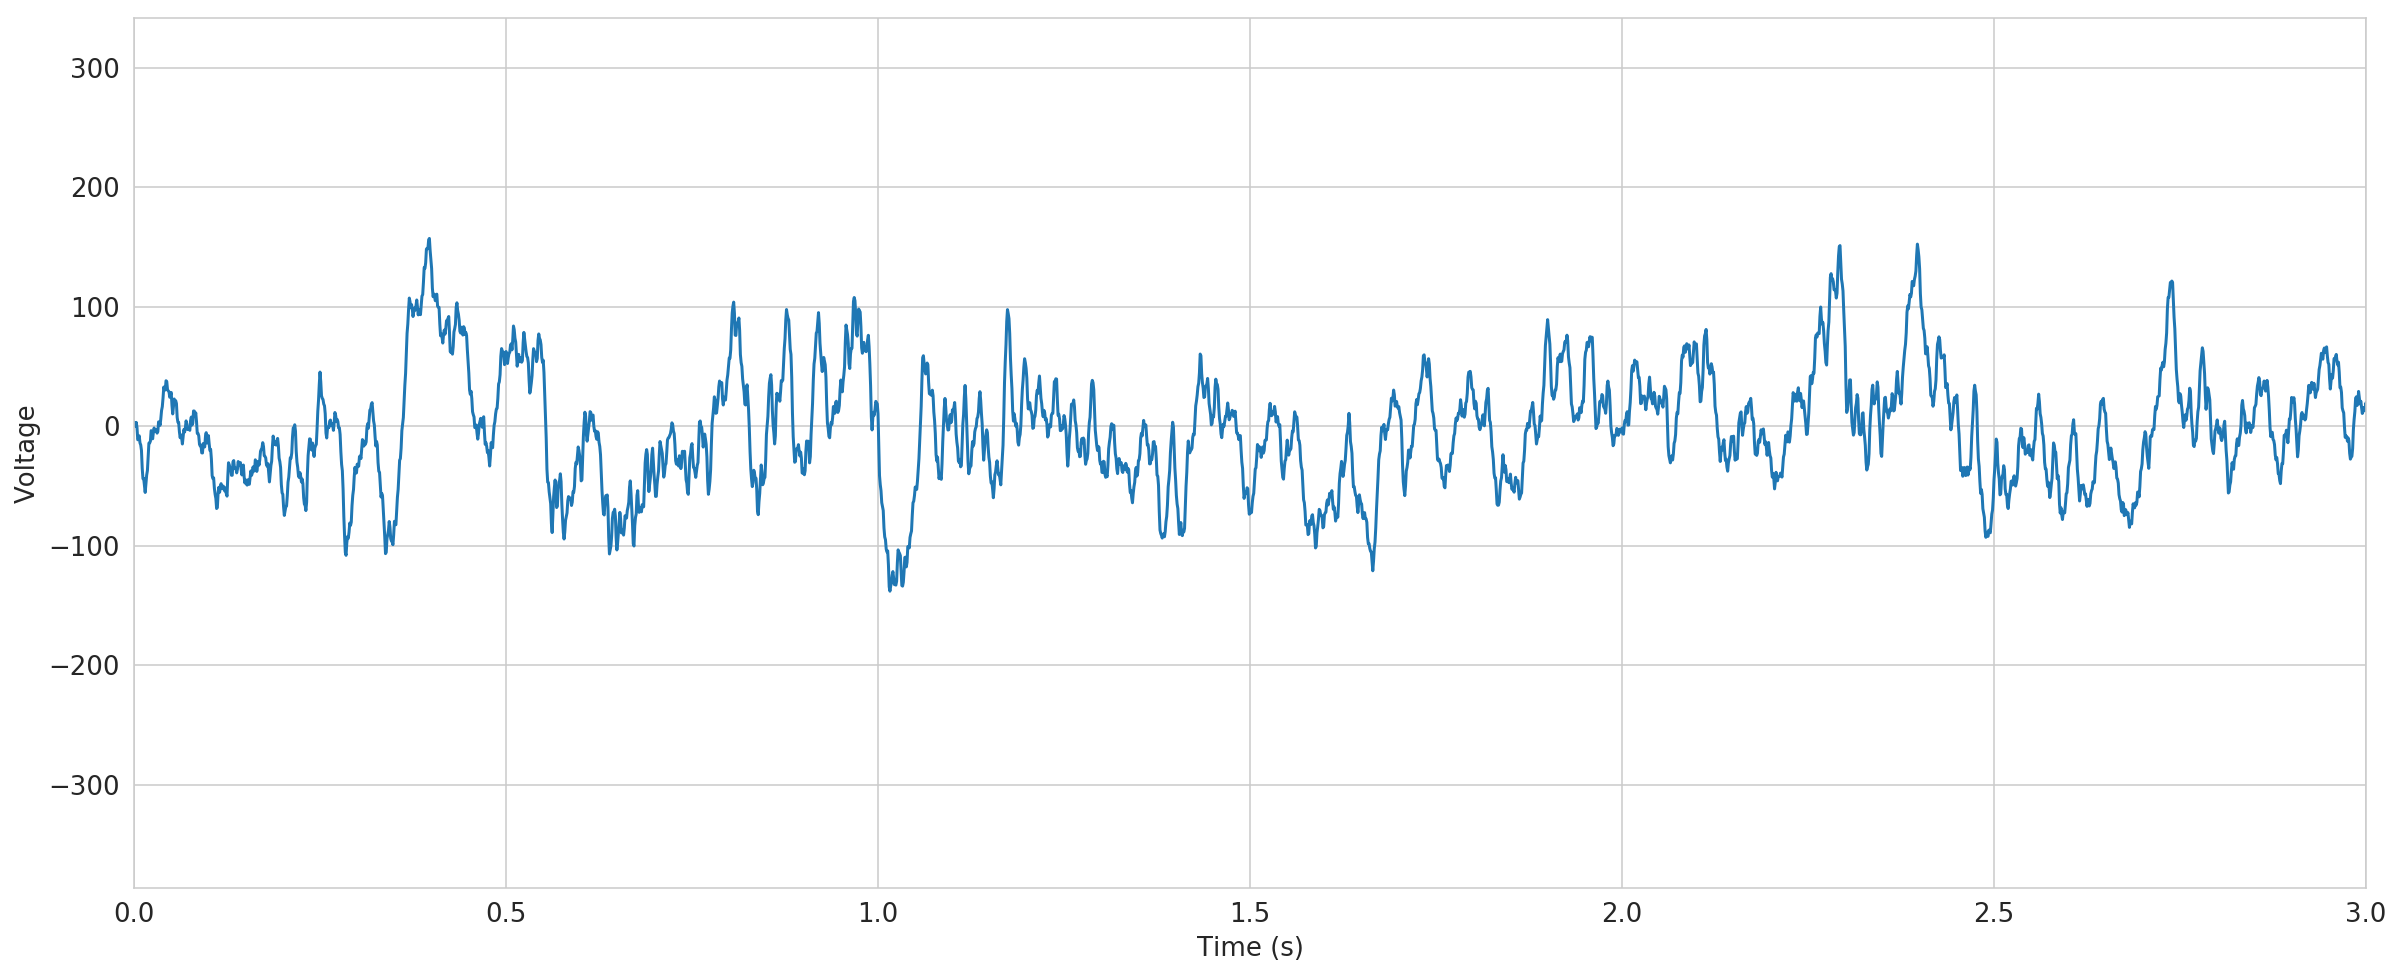

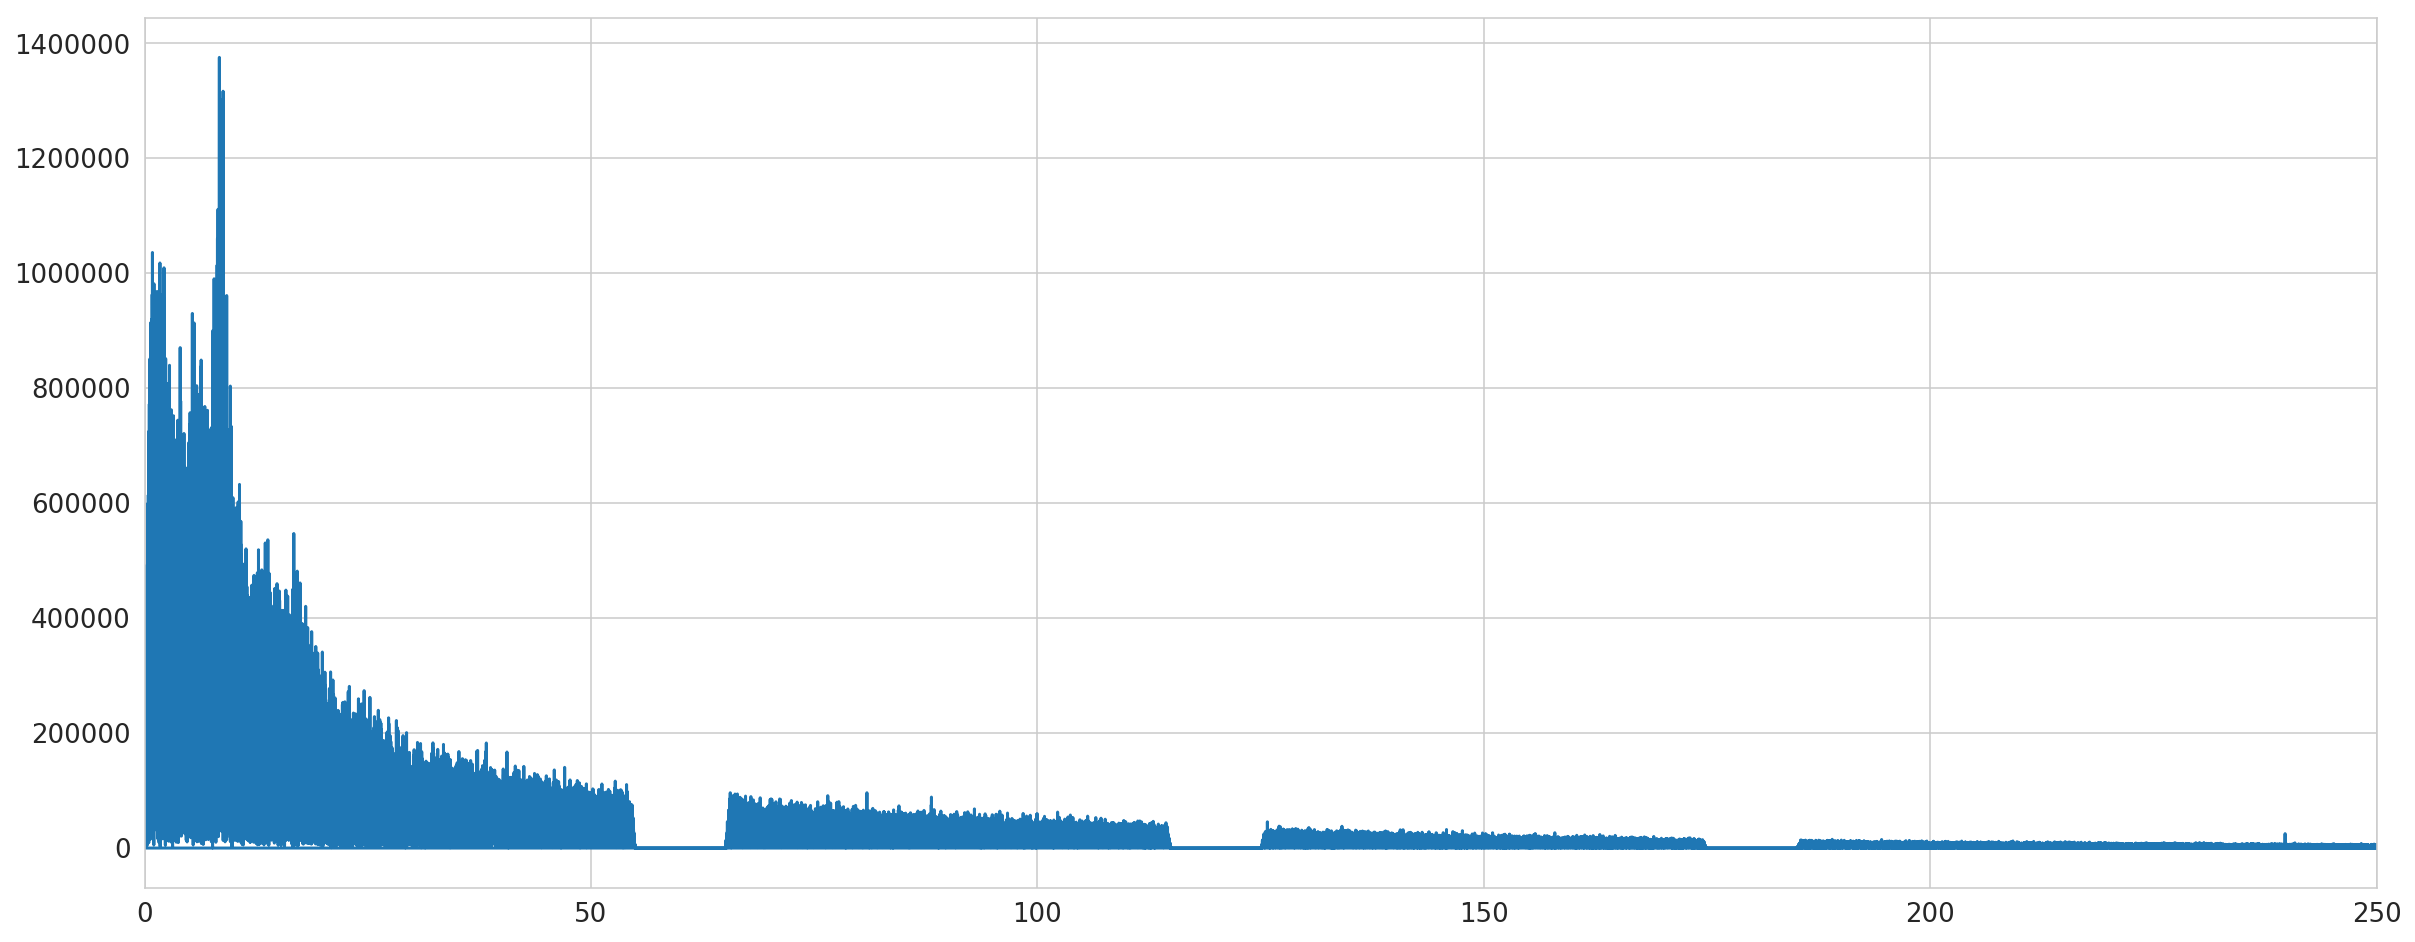

In [13]:
fs = 1000 # this is the sampling rate of the data, in HZ

# load the visual cortical ECOG channel, and the event indicces
data = io.loadmat('data/ecog_data.mat', squeeze_me=True)
sta = data['sta']
tar = data['tar']
resp = data['resp']
data = data['data']

# plot some of the data
t = np.arange(len(data))/fs
plt.plot(t, data)
plt.xlim((0,3))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

sp = np.abs(np.fft.fft(data)) # get the power spectrum of the ECoG data
freq = np.fft.fftfreq(data.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((0, 250))
plt.show()


### This is a _very noisy_ power spectrum, and hard to interpret.

### Also notice the "gaps" in the spectrum around 60, 120, and 180 Hz. This shows that a notch filter has been applied around the 60 Hz line noise, and its harmonics, to "zero out" the power in those frequencies.

### Because this is so noisy, and we don't need the super high-fidelity frequency resolution the real data has, we'll window our data, FFT each window, and average those FFTs together to get a lower frequency resolution, but "cleaner", power spectral density.

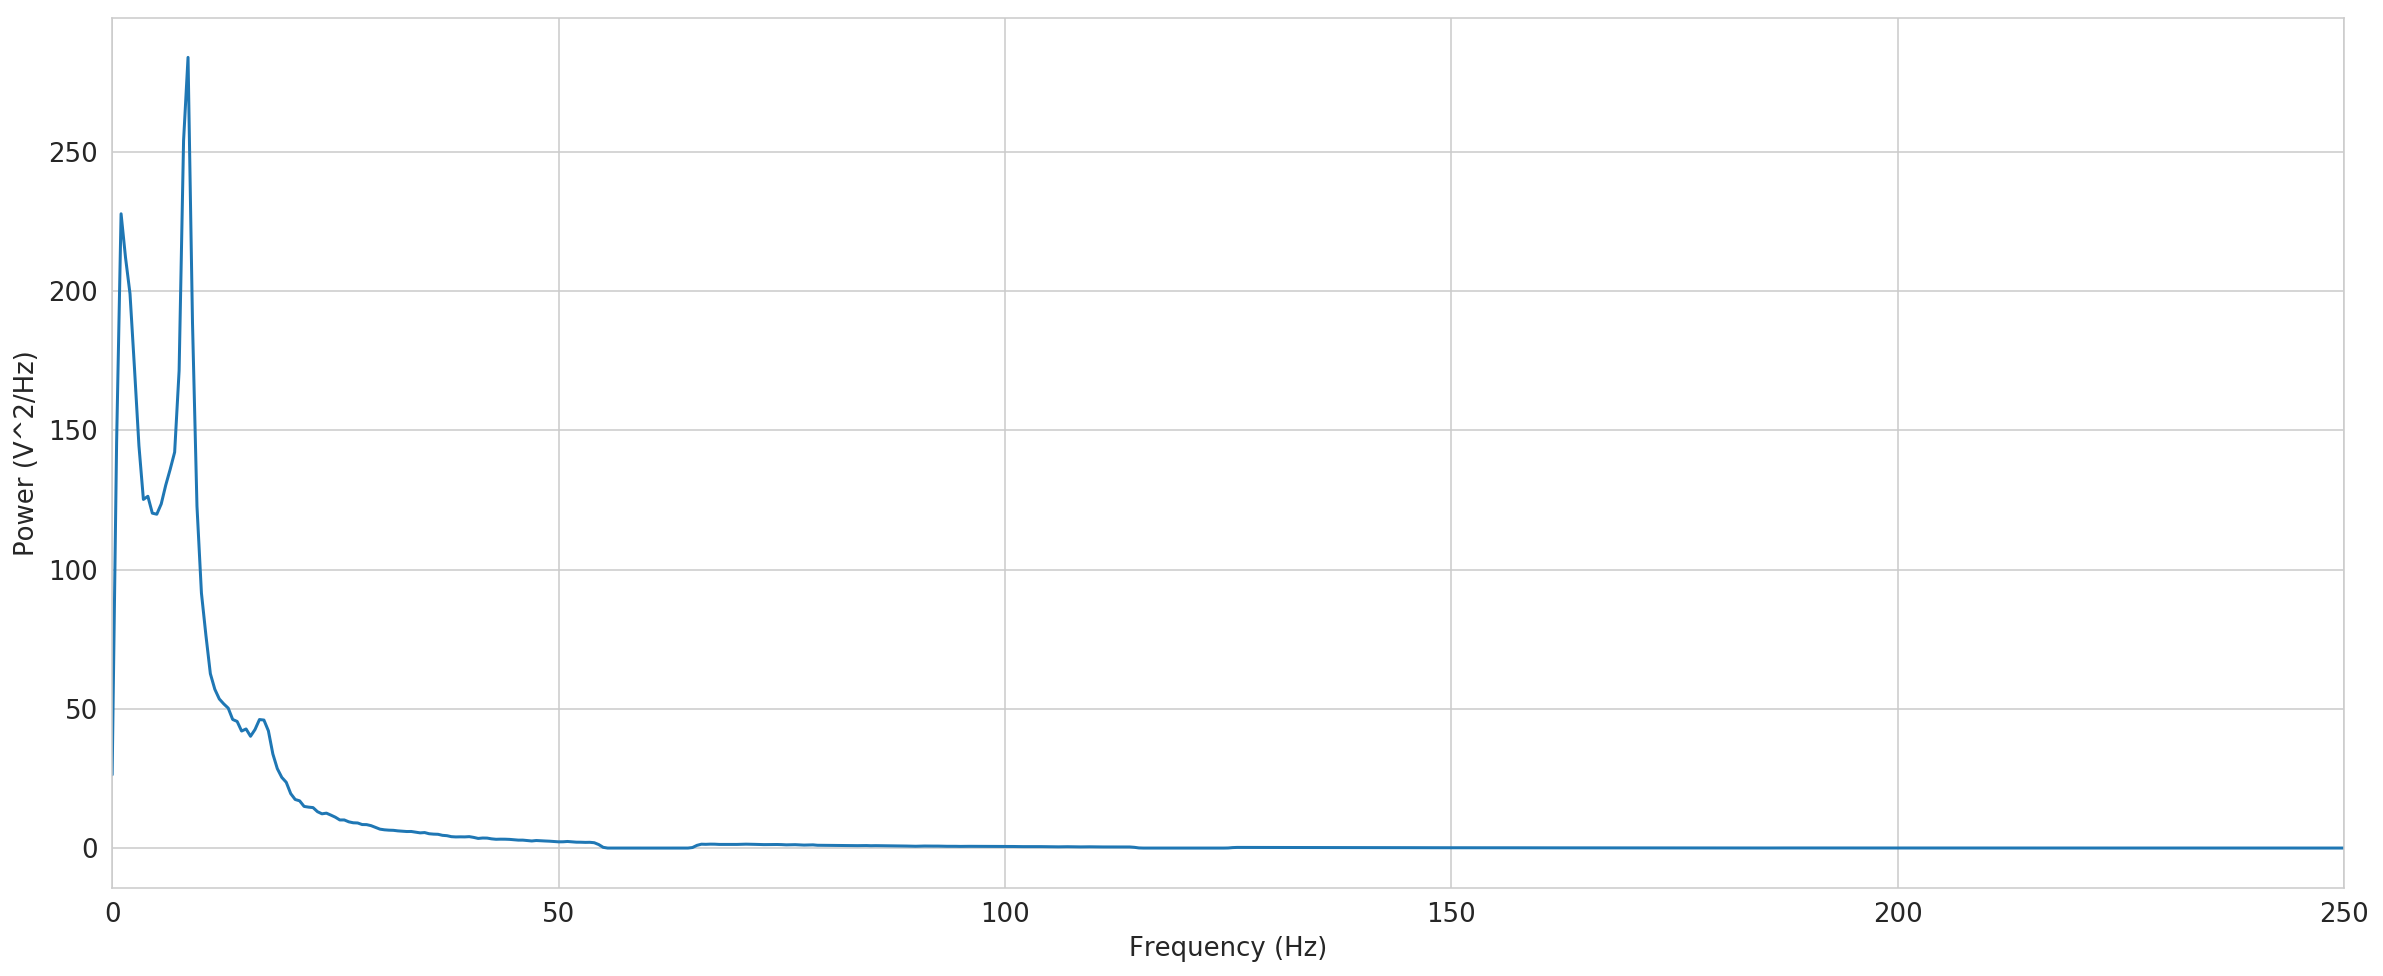

In [15]:
freq_mean, P_mean = spectral.compute_spectrum(data, fs, method='welch', avg_type='mean', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)

# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='mean')

plt.plot(freq_mean, P_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, 250))
plt.show()


### Here the "1/f" aspect of the data is clear: the lowest frequencies have _exponentially higher_ power than the highest frequencies. We can't even see the power above ~100 Hz.

### We can also see a _huge_ burst of power at around 10 Hz. This is a very clear, strong, alpha oscillation in the visual cortex. We also see a little bump of power at around 20 Hz. Later we'll explore to see if that a "real" ~20 Hz beta oscillation, or something else.

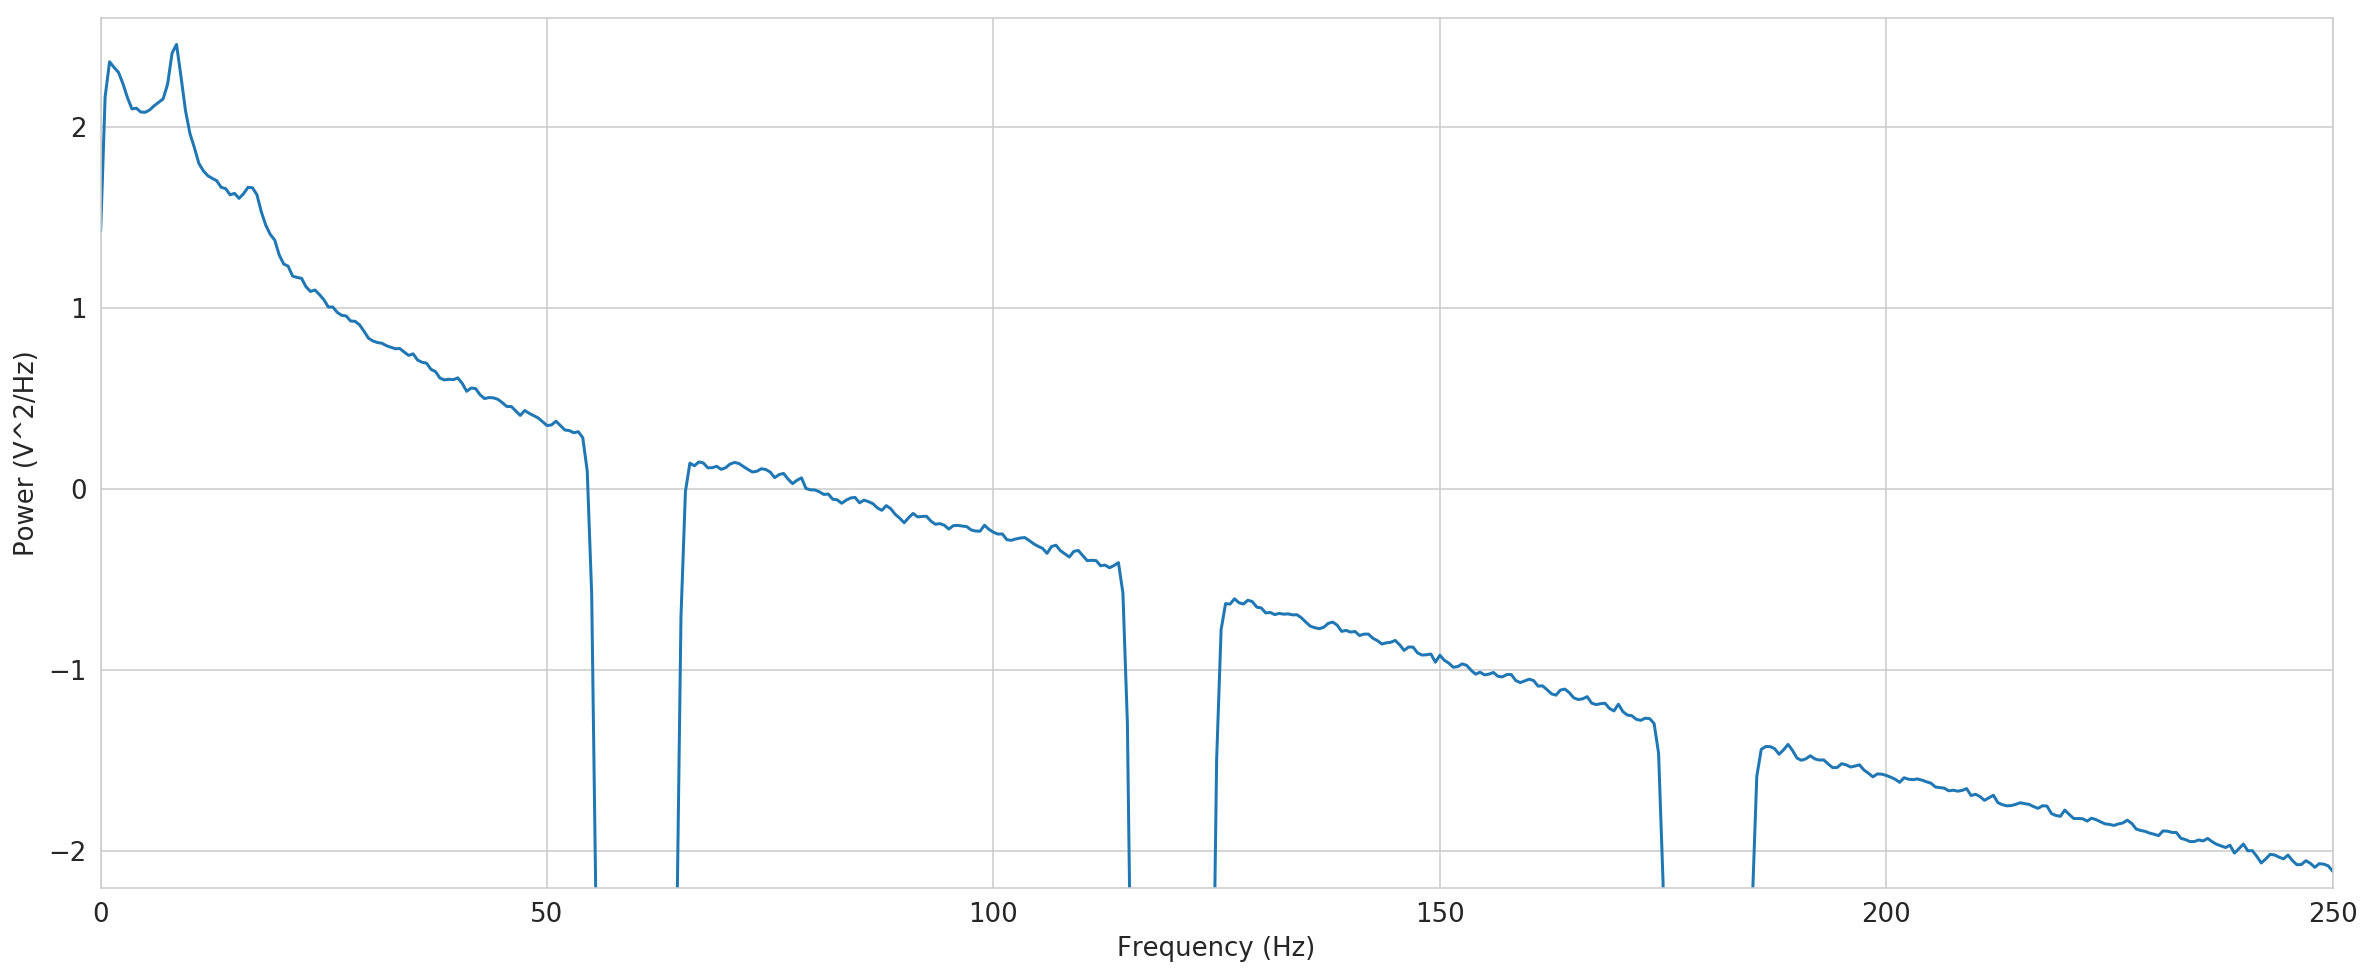

In [16]:
# plot again, but log scale the power

plt.plot(freq_mean, np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, 250))
plt.ylim((-2.2, 2.6))
plt.show()

### Note that if we log-scale the power (y-axis) it starts to look like a straight line, except for the oscillatory bumps and the notch filters.

### Let's zoom in on just the < 60 Hz regions...

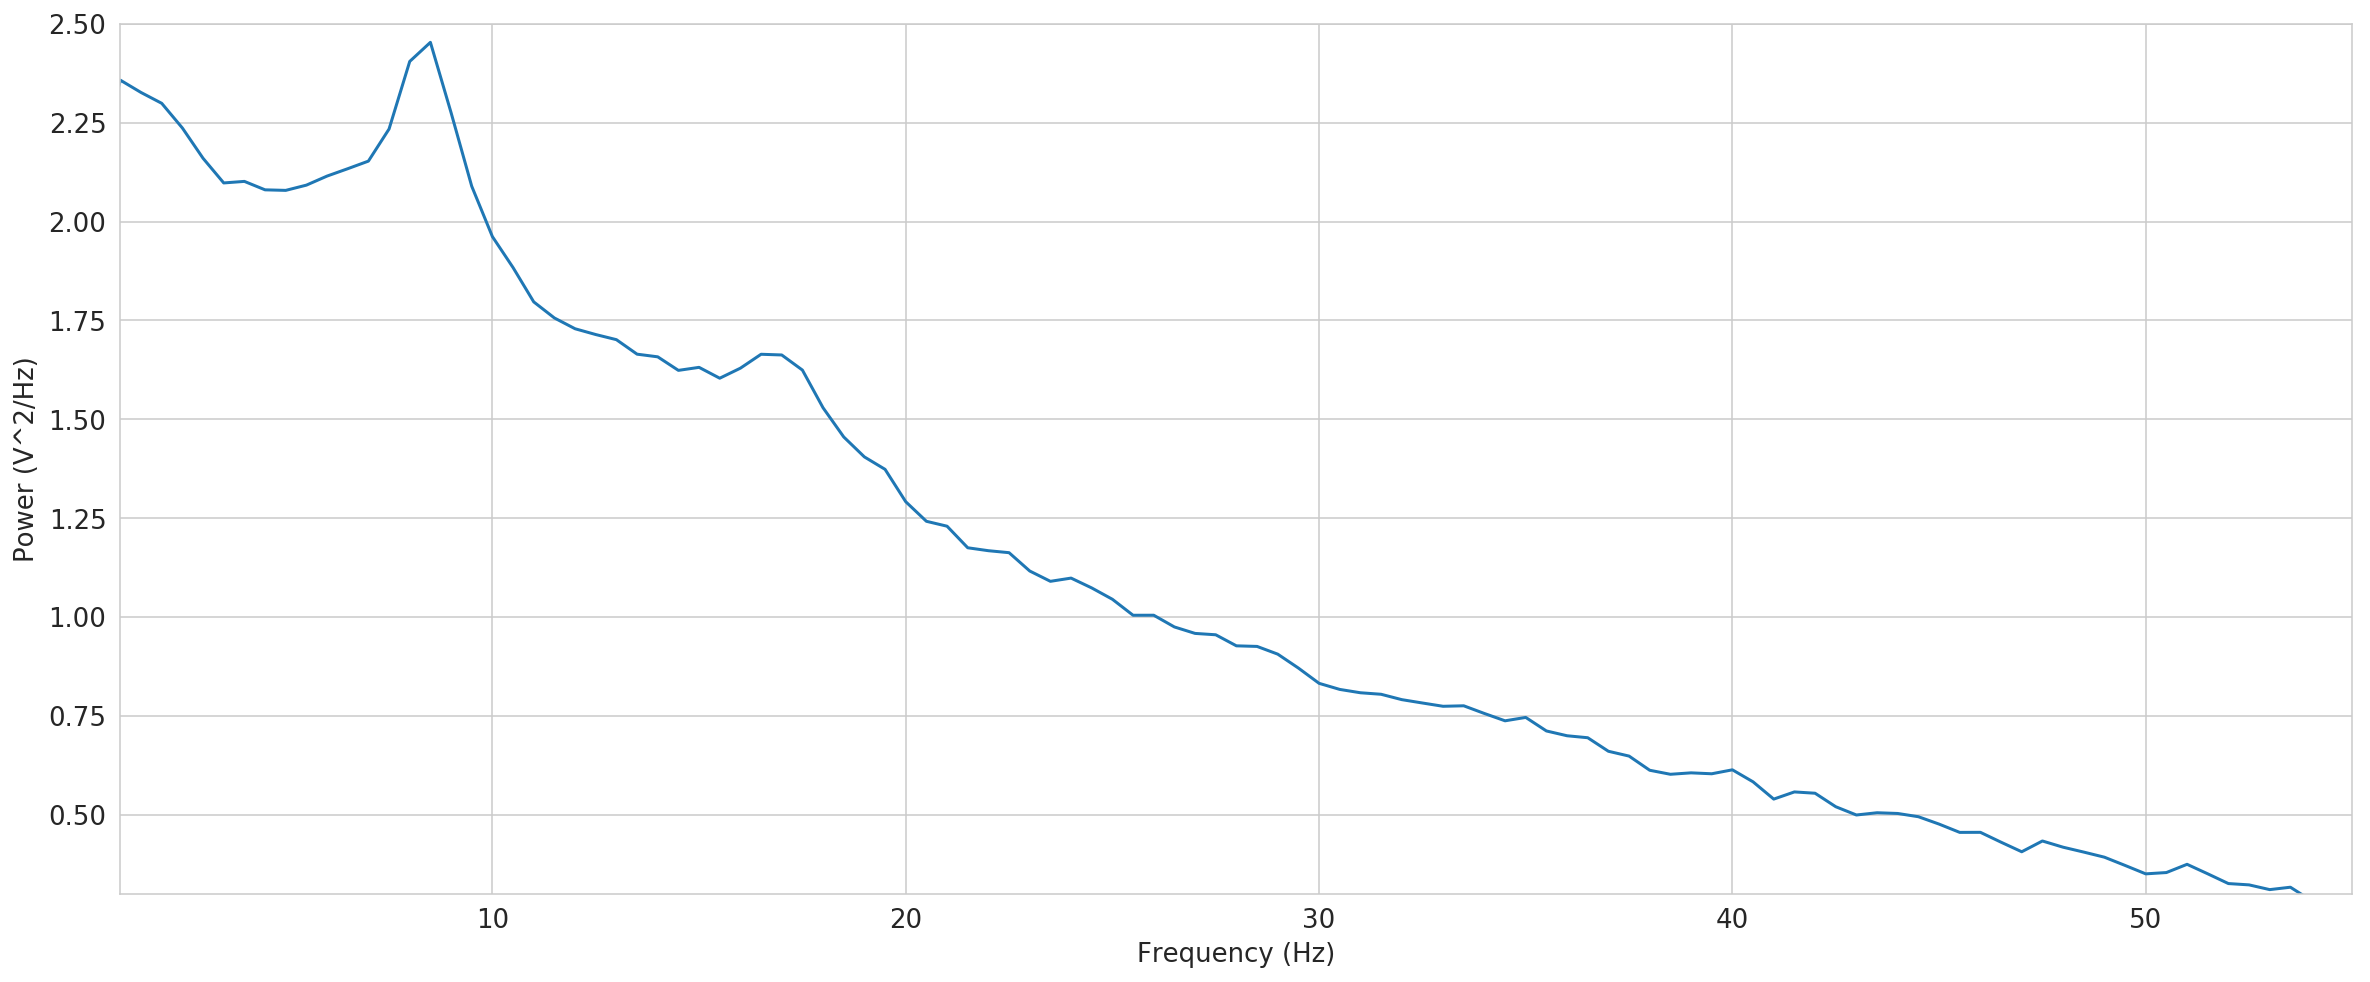

In [17]:
# plot again, but log scale the power, zoom in below 60 Hz, and log scale the frequency axis

plt.plot(freq_mean, np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((1, 55))
plt.ylim((0.3, 2.5))
plt.show()

### Now that's a beautiful power spectrum!

### So what can we do with this?

### One thing is to filter our data in our frequency and of interest.

### Here we'll start with the "canonical" alpha, which is ~8-12 Hz.

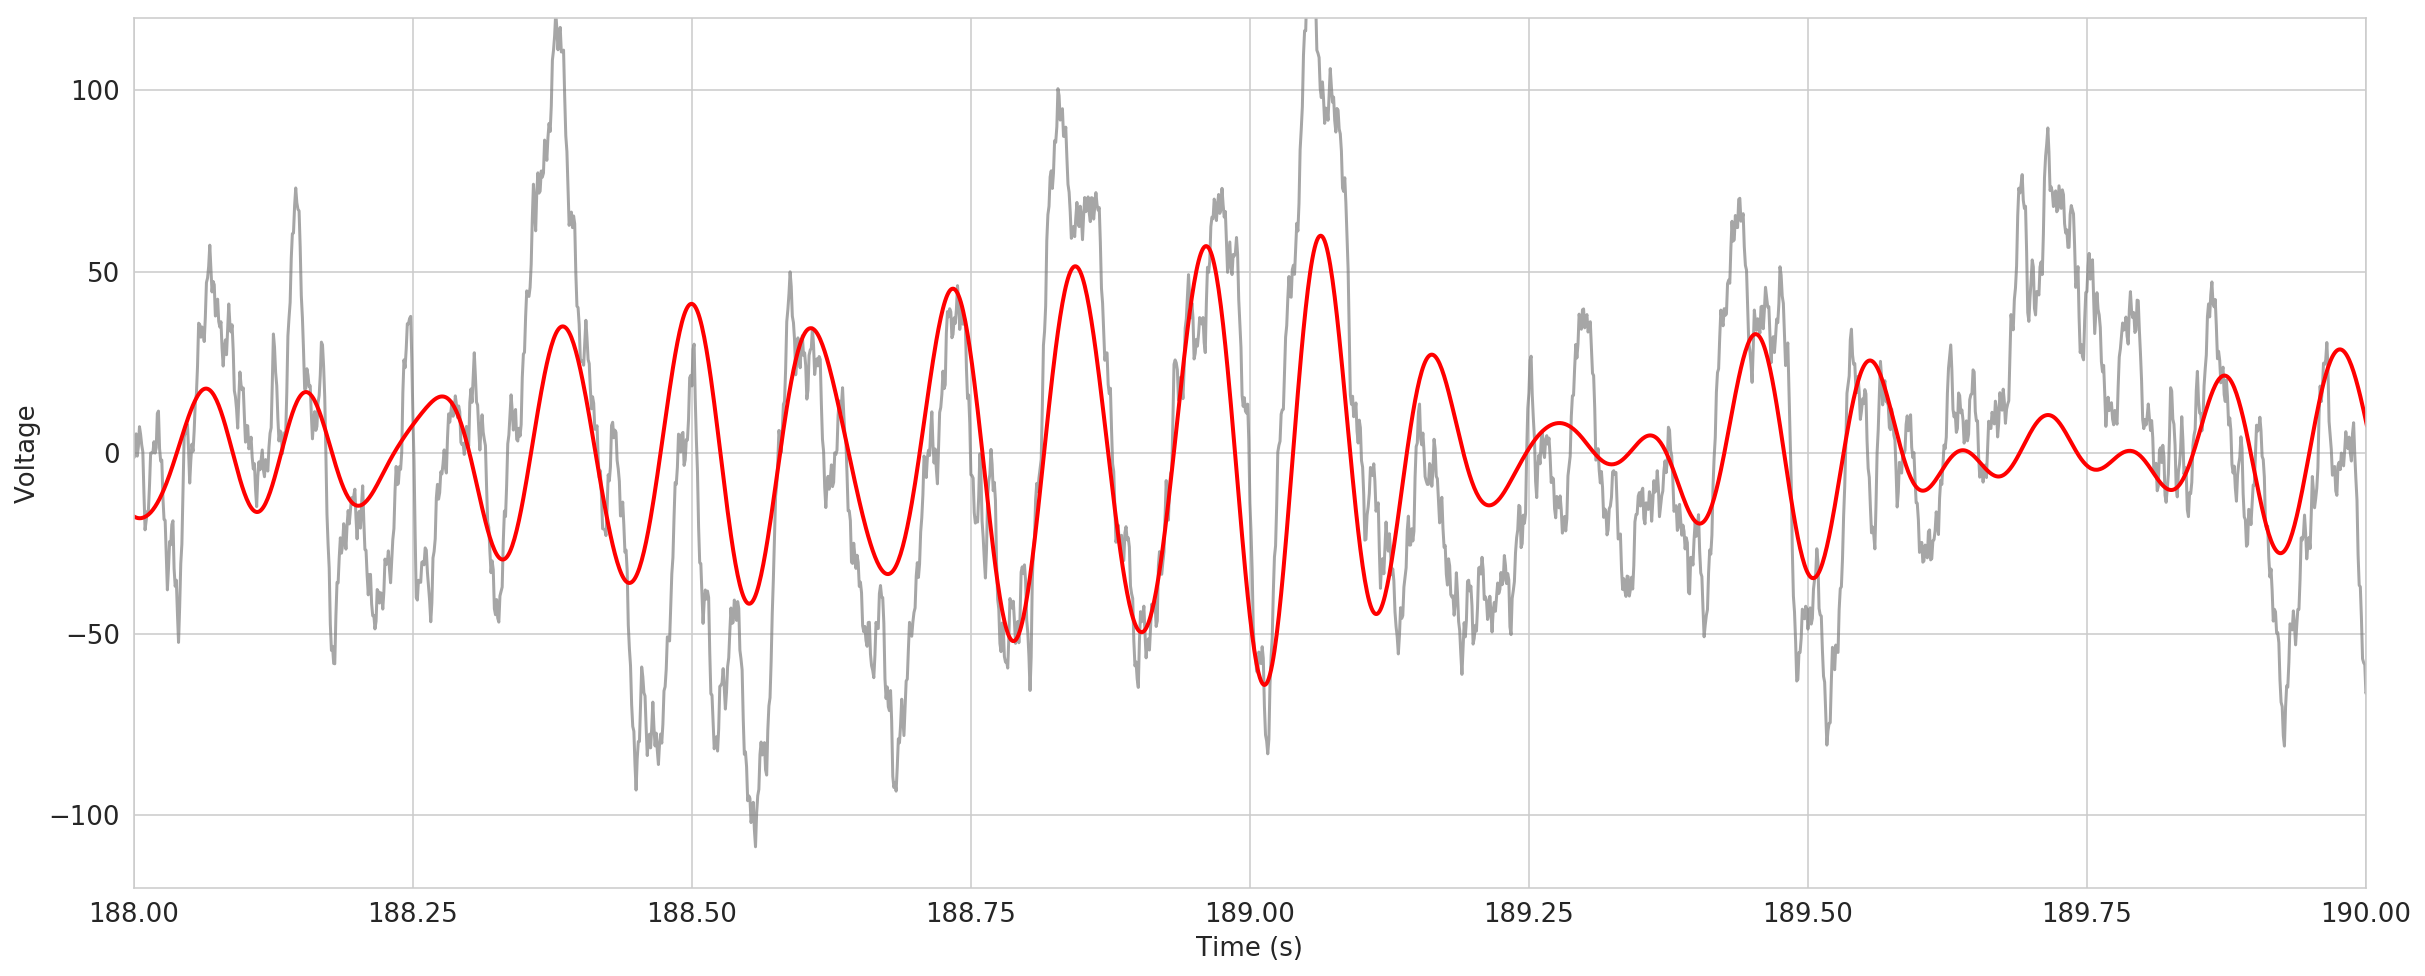

In [19]:
# Define the frequency band of interest
fc = (8,12)

# Filter the data
alpha_data = filt.filter_signal(data, fs, 'bandpass', fc)

plt.plot(t, data, 'grey', alpha=0.7)
plt.plot(t, alpha_data, 'r', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.xlim((188,190))
plt.ylim((-120,120))
plt.show()

### You can see the filter is doing its best to remove the higher frequency stuff while keep the rhythmic alpha structure.

### Now let's start to look at the event-related stuff. There are three event types in these data: non-target "standard" stimuli (sta), targets to which the subjects were to respond via manual button press (tar), and the times when they responded (resp).

### First, let's look at the distribution of response times. To get the per-event response time, in ms, we must subtract the times of the visual target onsets from the response event times. Normally we would then have to convert these times to ms, but because the sampling rate is 1000, nothing needs to be done.

In [20]:
conversion_factor = (1/fs)*1000 # convert from time points to ms
print(conversion_factor)


1.0


### See, the converstion factor ends up being 1. But in the code below I'll continue to use it, so you can adopt it to your own data, if you'd like.

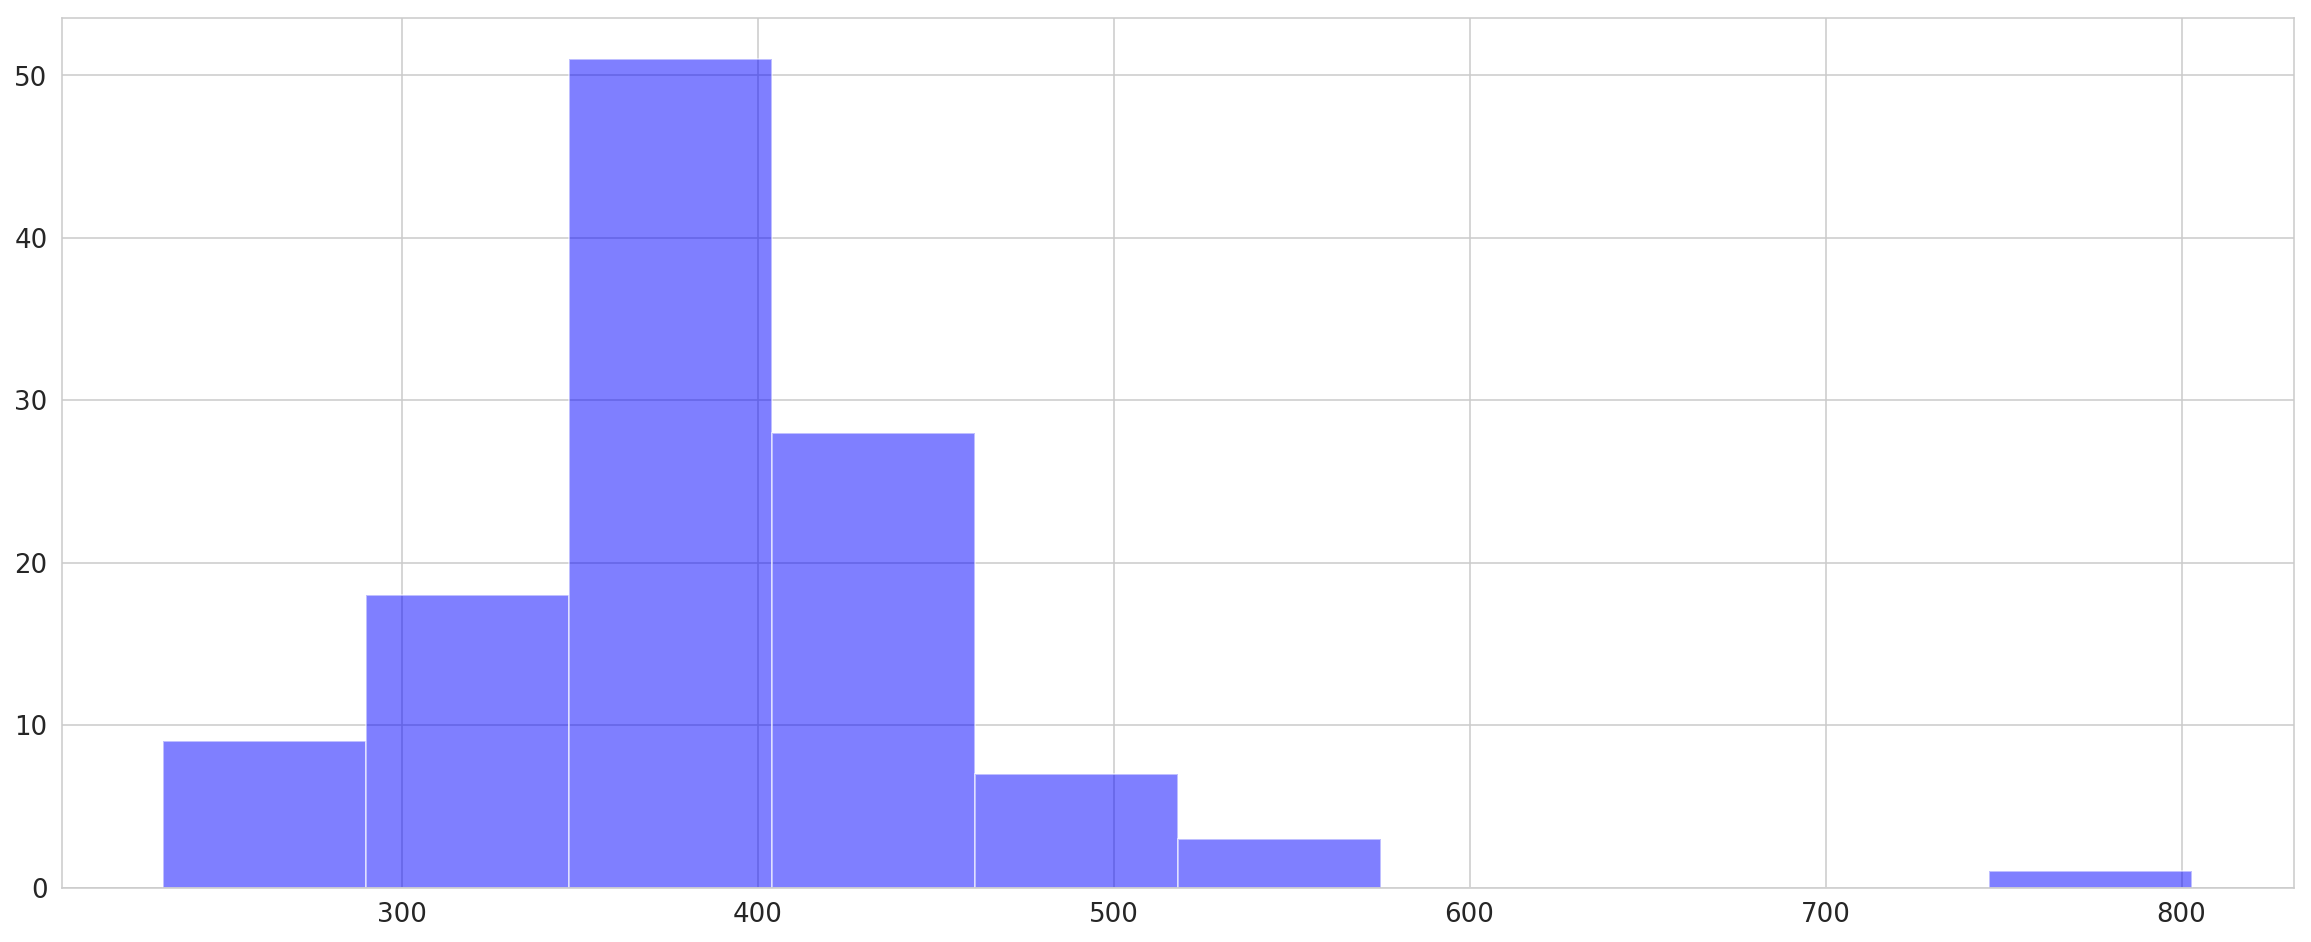

average response time = 387.38461538461536


In [24]:
rt = (resp-tar) * conversion_factor

plt.hist(rt, color='b', alpha=0.5)
plt.show()
print(('average response time = ' + str(np.mean(rt))))

### Nice, normal-ish distribution of RTs, with maybe one "outlier" out there near 800 ms. But we'll leave it for now.

### Now let's take our data, and break it up into time windows around our events.

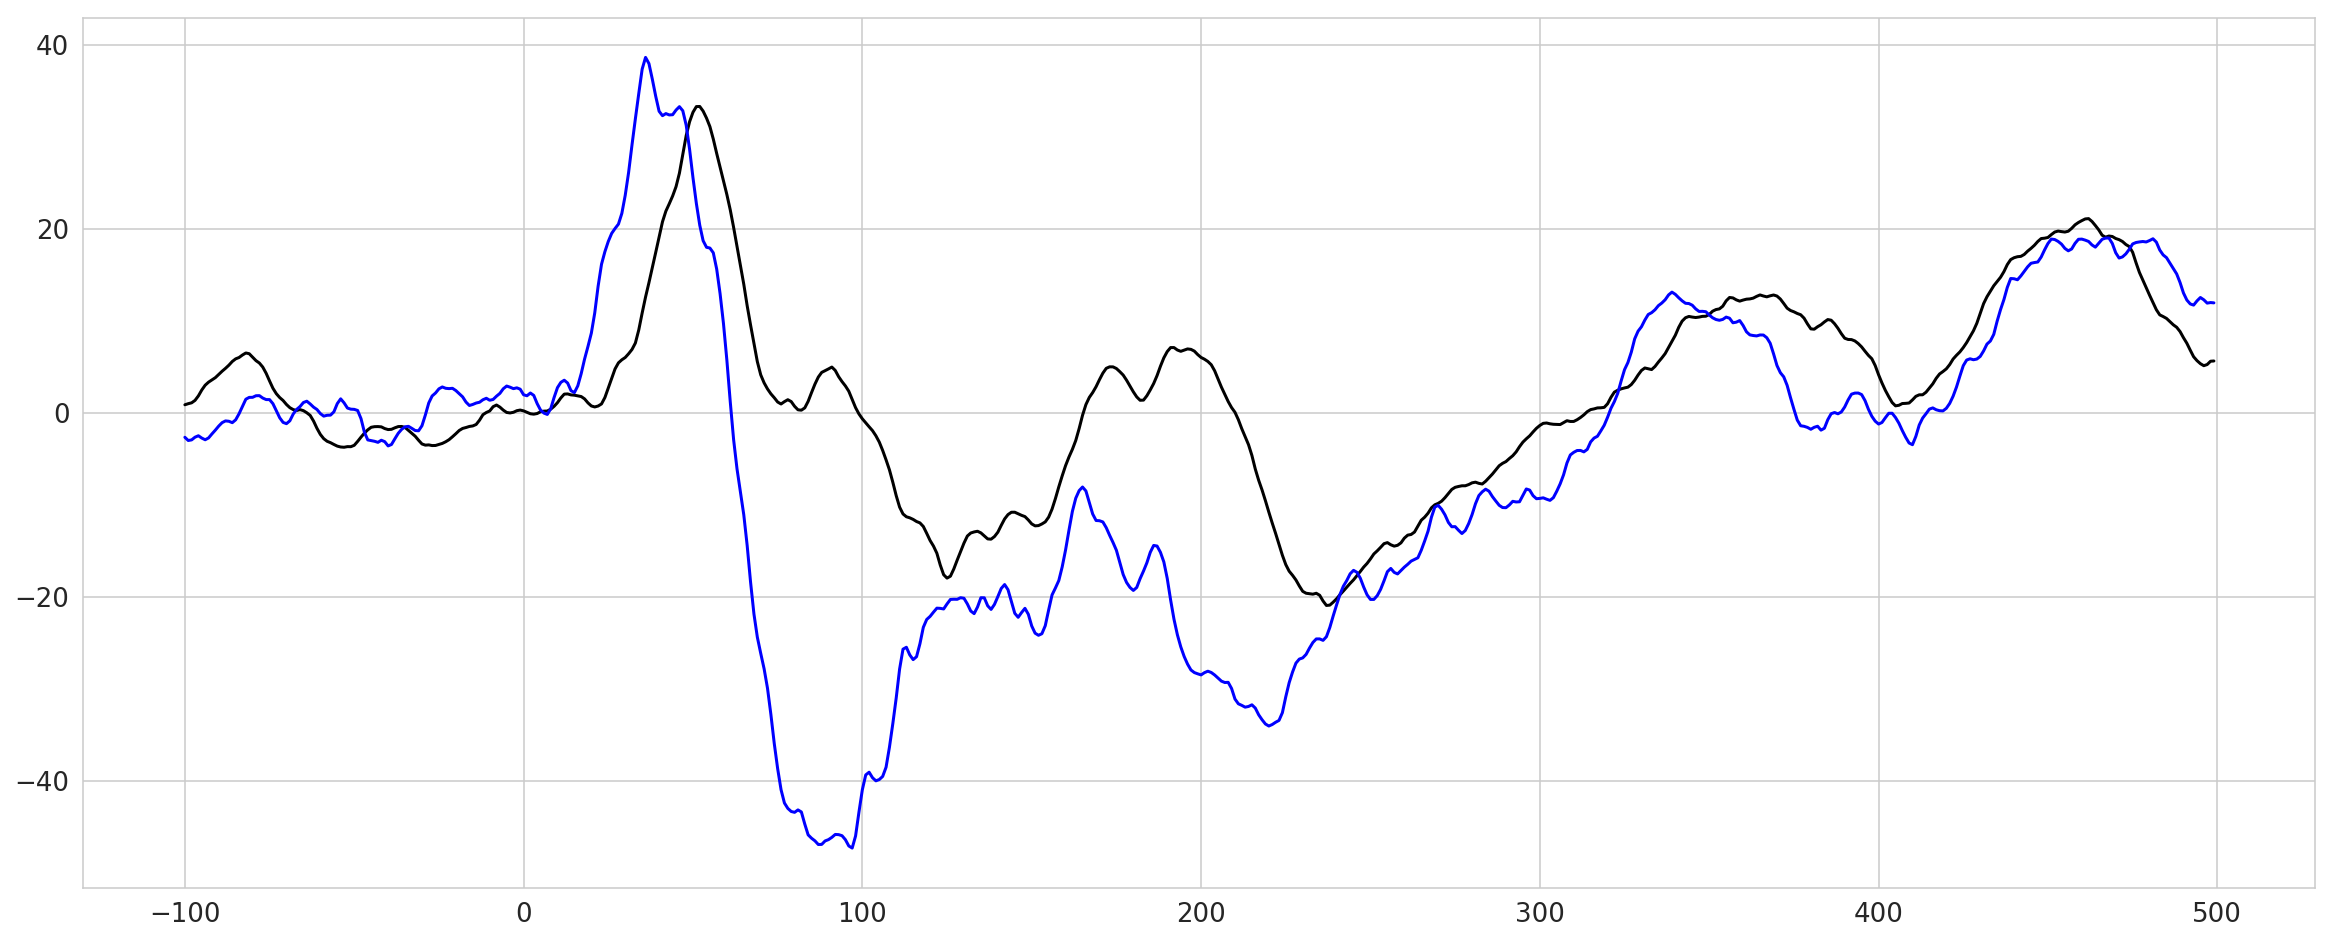

In [25]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # coonvert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

event_times, sta_erp = event_related(data, fs, sta, (-100,500), (-100,0))
event_times, tar_erp = event_related(data, fs, tar, (-100,500), (-100,0))

plt.plot(event_times, np.mean(sta_erp,0), 'k')
plt.plot(event_times, np.mean(tar_erp,0), 'b')
plt.show()


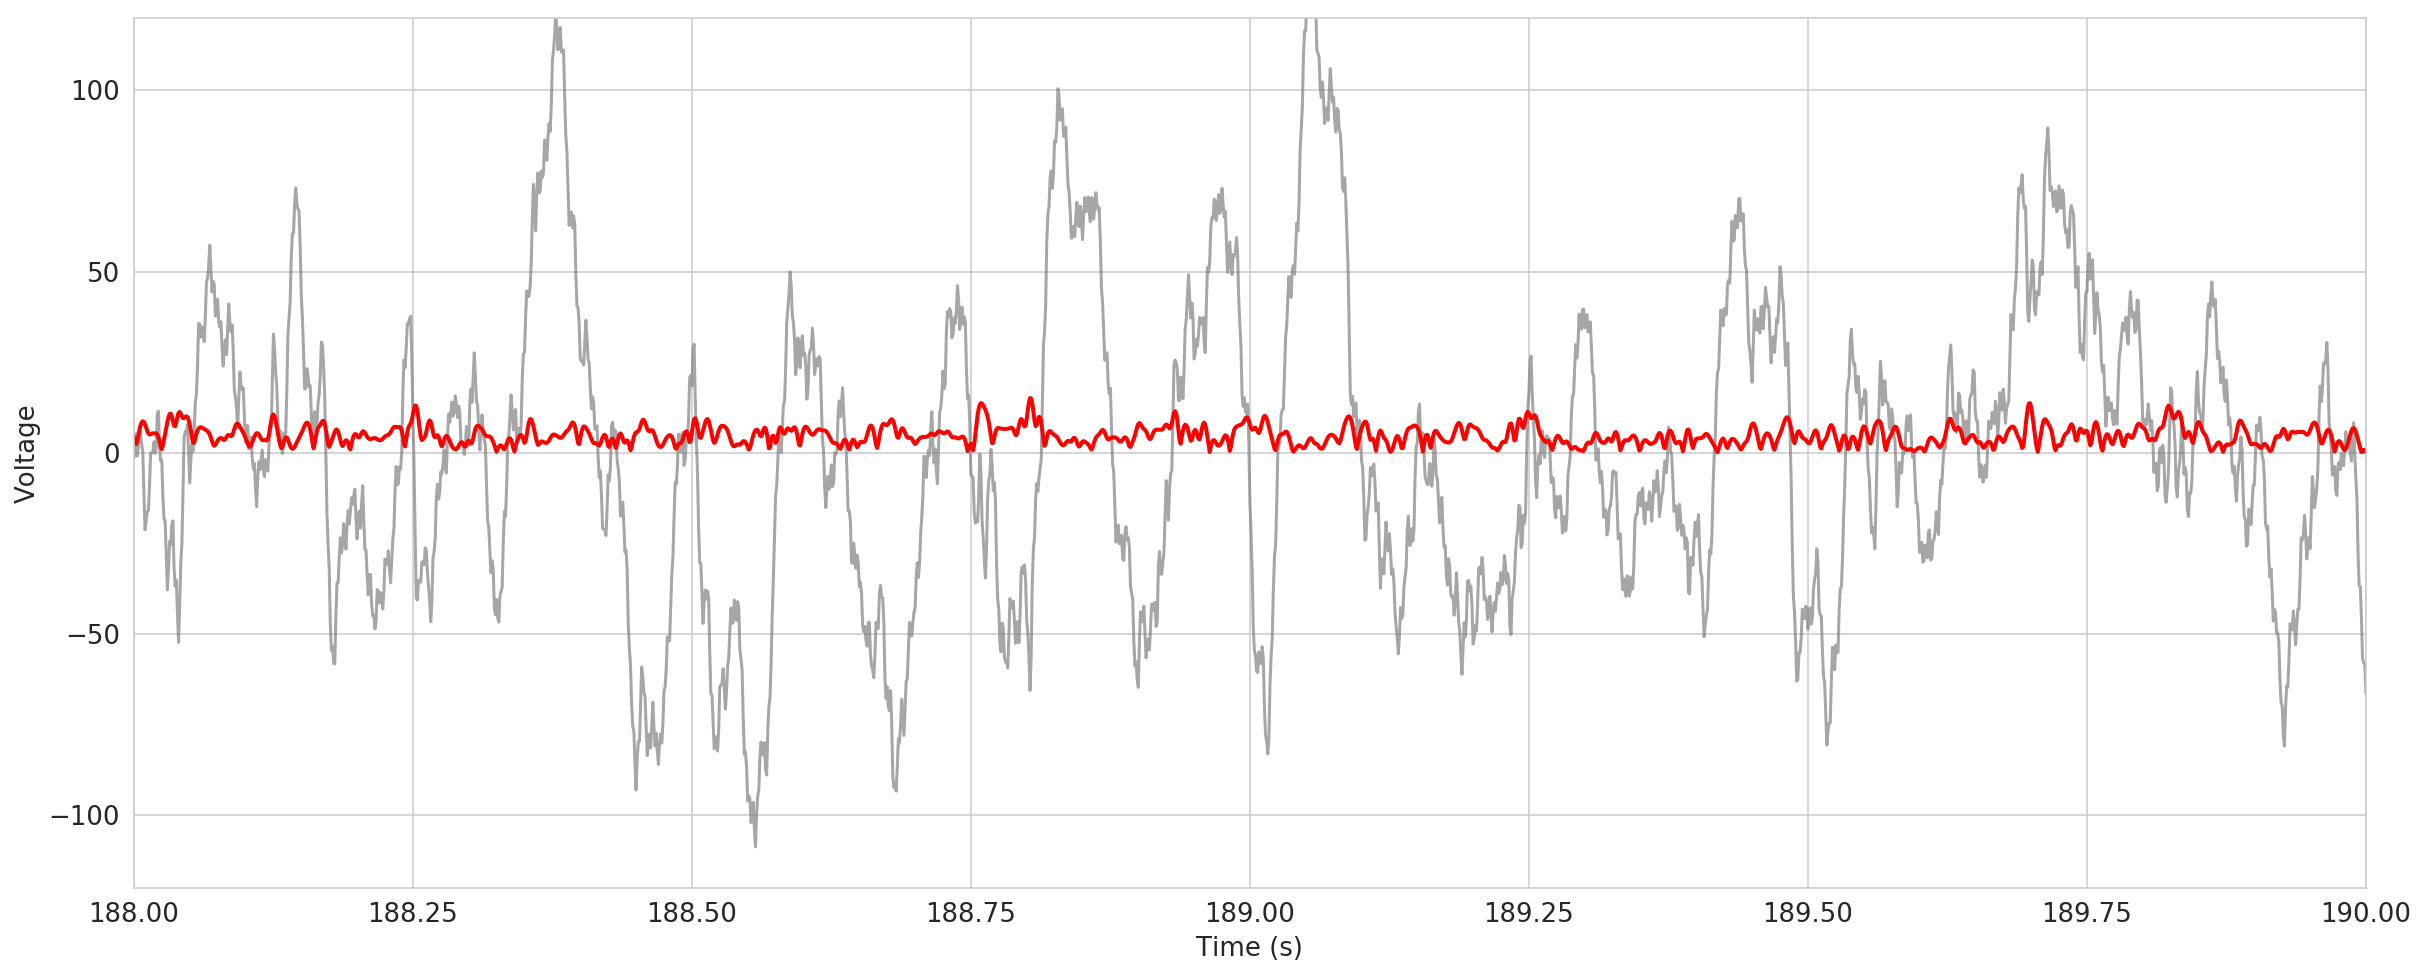

In [28]:
# Define the frequency band of interest
fc = (80,250)

# Filter the data
high_gamma = filt.filter_signal(data, fs, 'bandpass', fc, remove_edges=False)
high_gamma = np.abs(signal.hilbert(high_gamma))

plt.plot(t, data, 'grey', alpha=0.7)
plt.plot(t, high_gamma, 'r', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.xlim((188,190))
plt.ylim((-120,120))
plt.show()


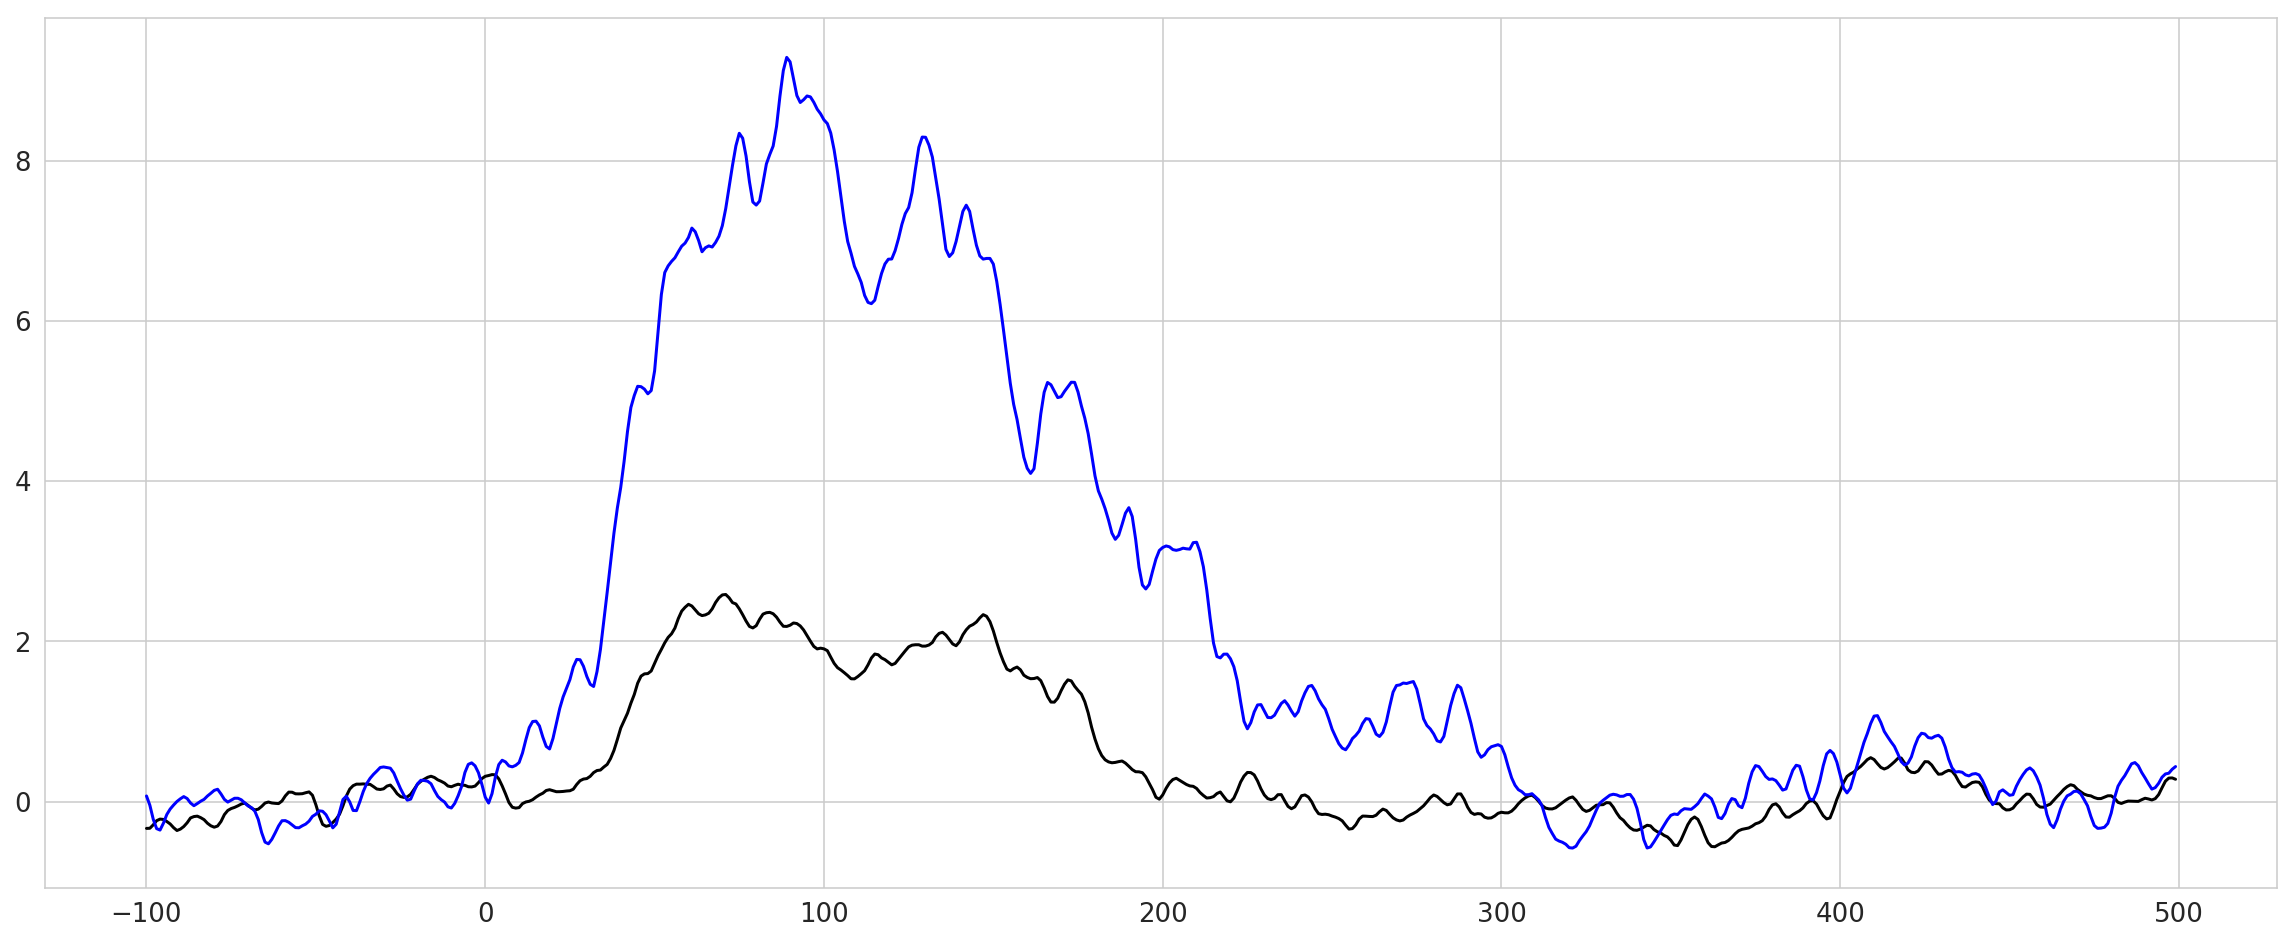

In [30]:
event_times, sta_gam = event_related(high_gamma, fs, sta, (-100,500), (-100,0))
event_times, tar_gam = event_related(high_gamma, fs, tar, (-100,500), (-100,0))

plt.plot(np.arange(-100, 500), np.mean(sta_gam,0), 'k')
plt.plot(np.arange(-100, 500), np.mean(tar_gam,0), 'b')
plt.show()

### Now let's do this, but for all frequencies

In [60]:
fc_lo = np.arange(3, 249, 2)
fc_hi = np.arange(5, 251, 2)

# Filter the data
tar_ersp = []
i_freqs = np.size(fc_hi)
for i in range(i_freqs):
    filt_dat = filt.filter_signal(data, fs, 'bandpass', (fc_lo[i], fc_hi[i]), remove_edges=False)
    filt_dat = np.abs(signal.hilbert(filt_dat))
    event_times, foo = event_related(filt_dat, fs, tar, (-100,500), (-100,0))
    tar_ersp.append(foo)
tar_ersp = np.asarray(tar_ersp)


/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  2.9  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  2.9  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  3.9  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  3.9  Hz. This is greater than the desiredpass/stop bandwidth o

/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  20.5  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  22.5  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  21.5  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  22.5  Hz. This is greater than the desiredpass/stop bandwid

/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  42.0  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  43.0  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  42.0  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  42.0  Hz. This is greater than the desiredpass/stop bandwid

/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  57.6  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  58.6  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  58.6  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/neurodsp/filt/checks.py:139: UserWarning: Transition bandwidth is  58.6  Hz. This is greater than the desiredpass/stop bandwid

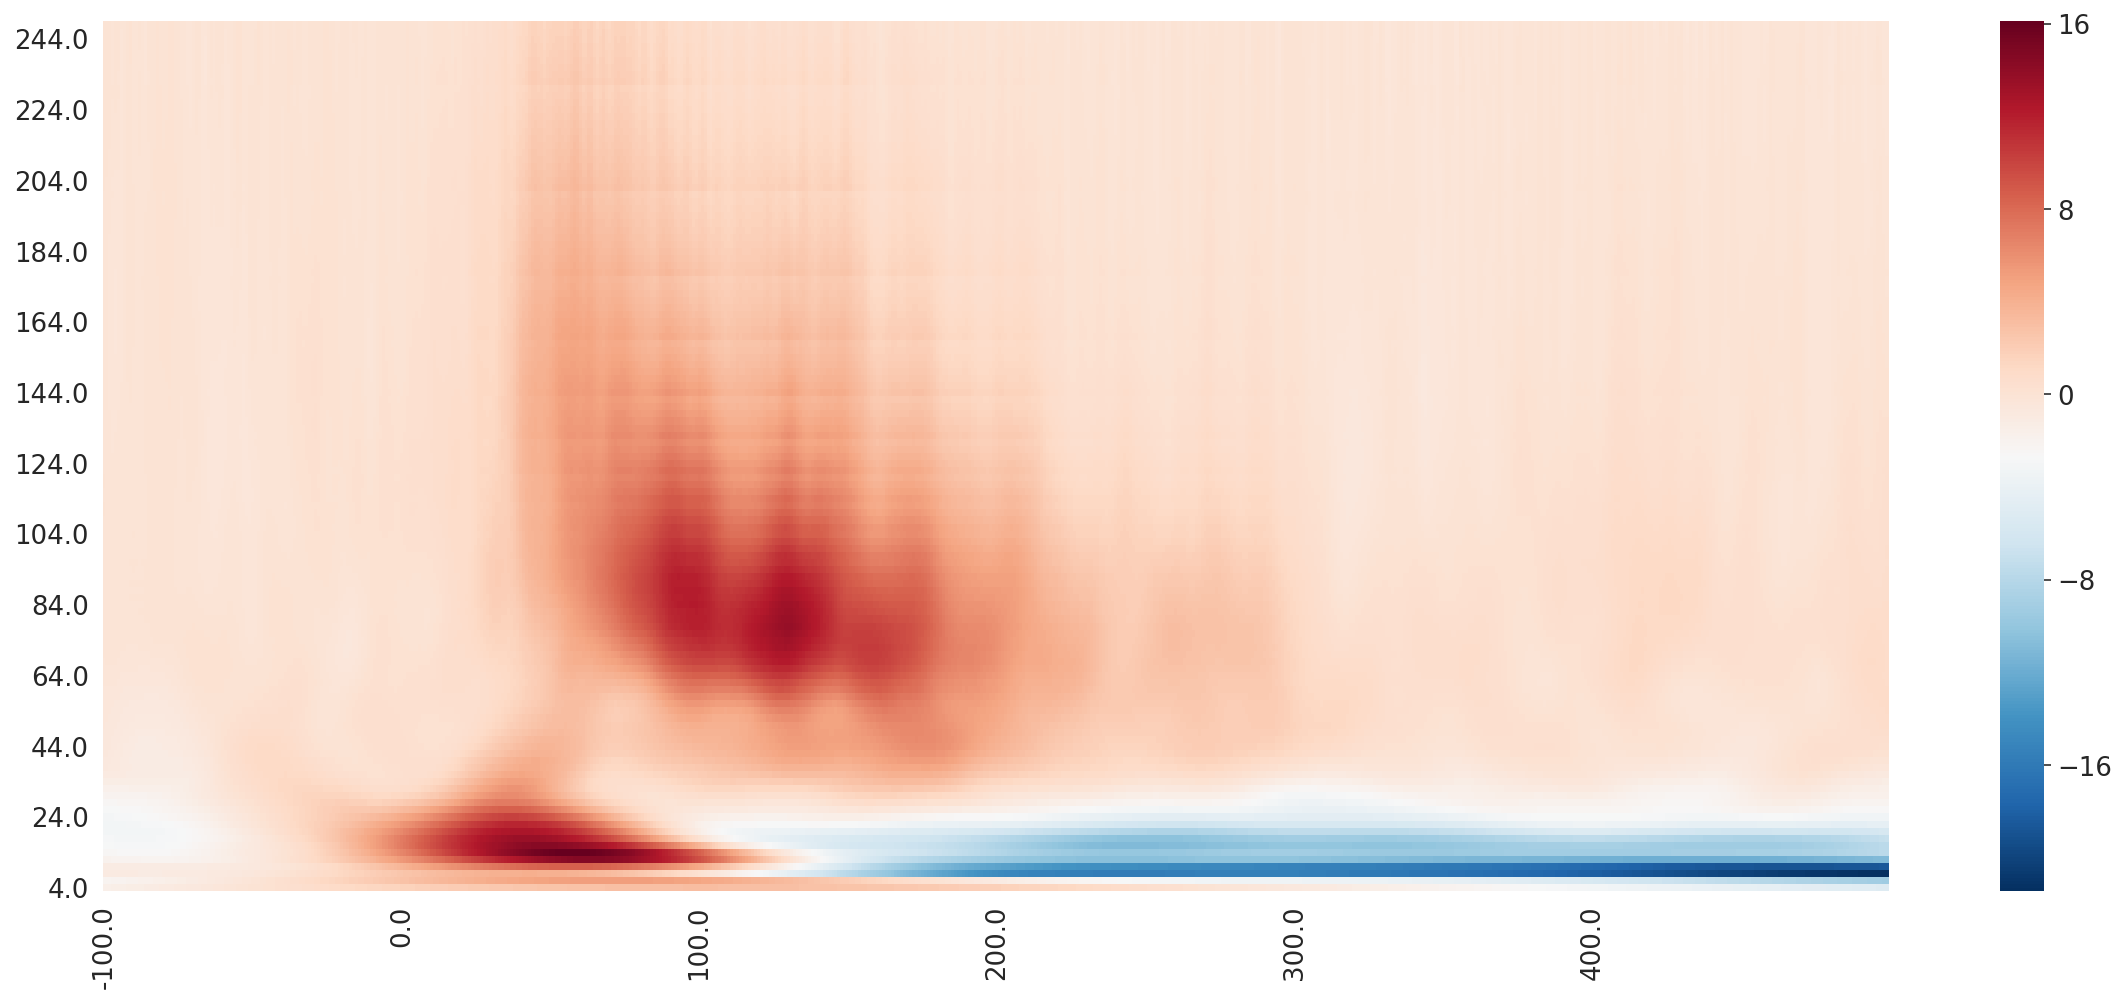

In [78]:
cmap = 'RdBu_r'
ax = sns.heatmap(np.mean(tar_ersp, 1), xticklabels=event_times, yticklabels=(fc_lo+fc_hi)/2, cmap=cmap)
ax.invert_yaxis()
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 100 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(ax.get_yticklabels()):
    if ind % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

### Directly compare spectra between conditions

In [31]:
fs = 1000

win_len = tar_erp.shape[-1]
hann_win = signal.hann(win_len)

freq = np.fft.fftfreq(win_len)*fs
fft_win = 0,int(np.floor(np.shape(freq)[0]/2))
fft_win = np.arange(fft_win[0],fft_win[1])
freq = freq[fft_win]

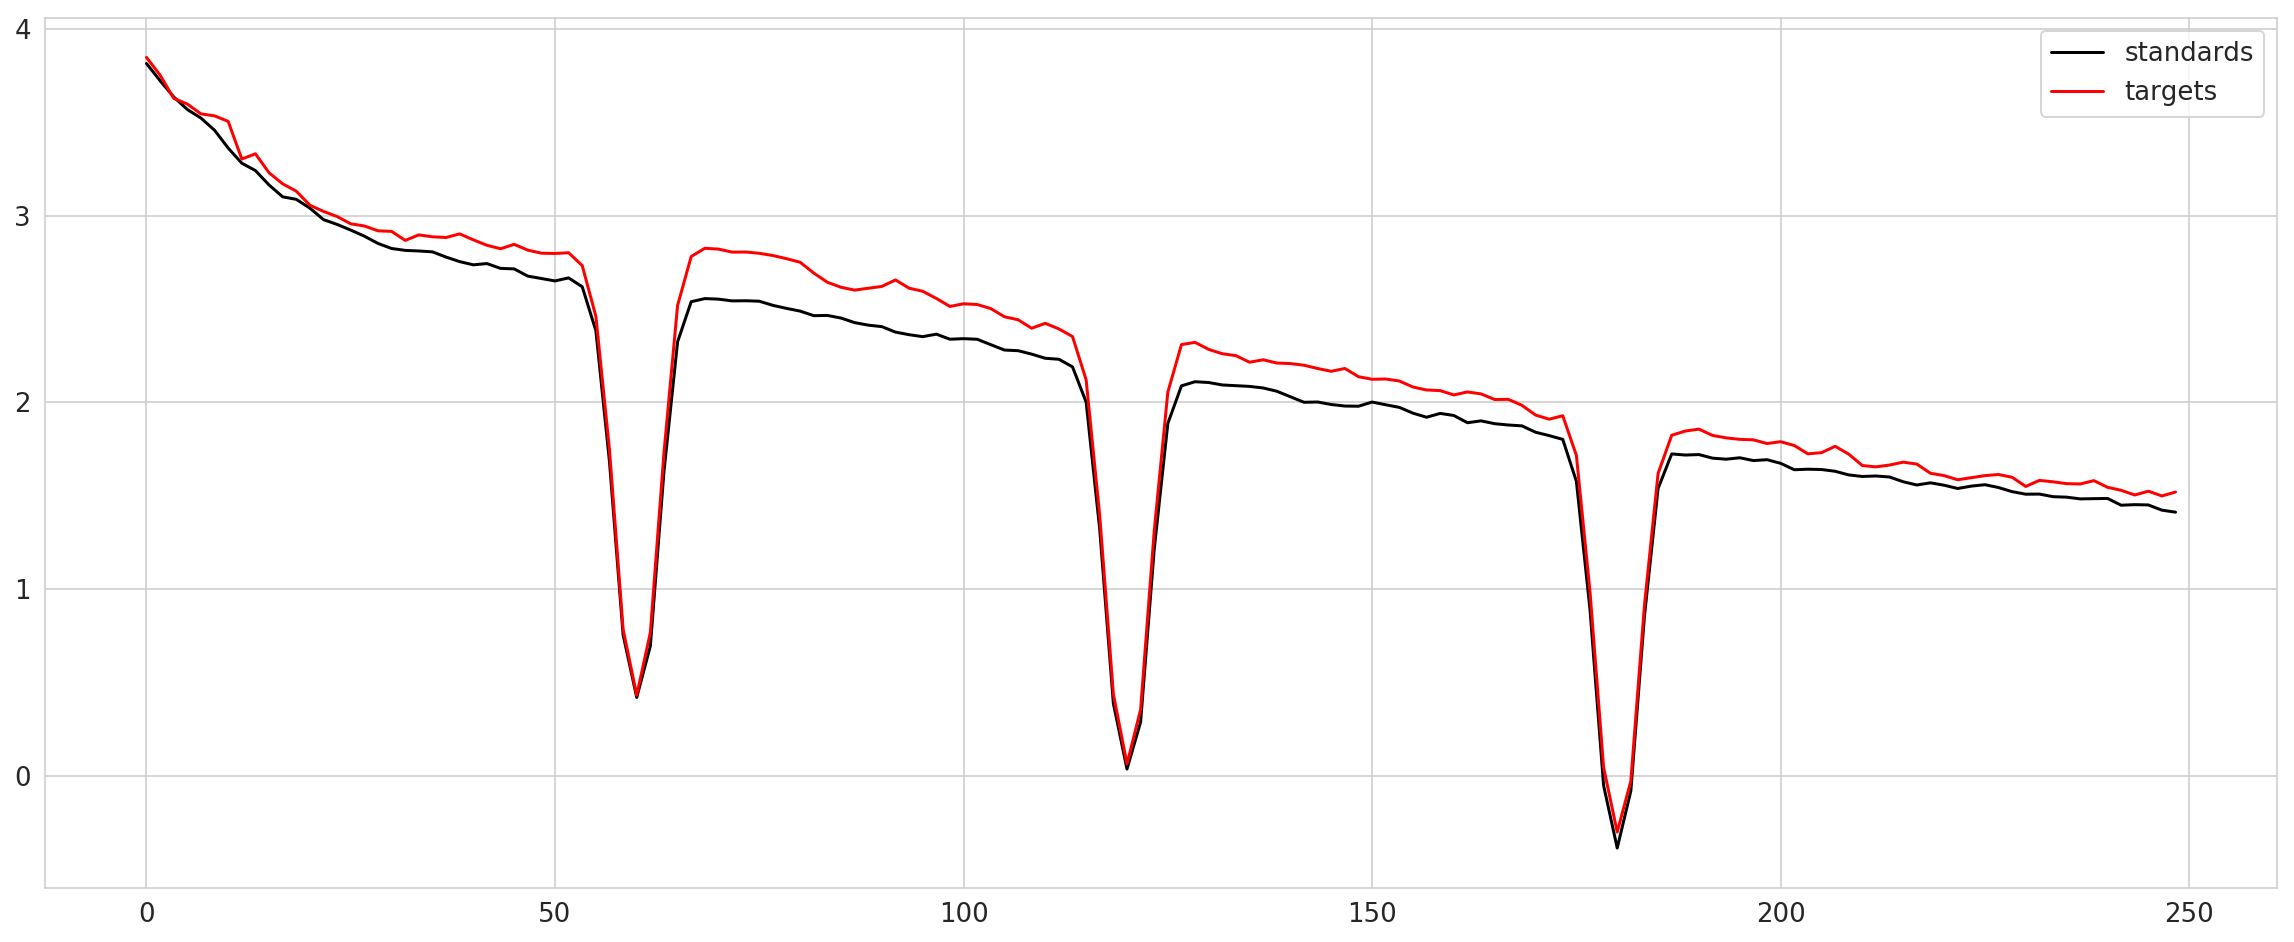

In [37]:
windowed_data = [hann_win*sig for sig in tar_erp]
windowed_data = np.asarray(windowed_data)
tar_fft = [np.abs(np.fft.fft(sig)) for sig in windowed_data]
tar_fft = np.asarray(tar_fft)
tar_fft = tar_fft[:,fft_win]

windowed_data = [hann_win*sig for sig in sta_erp]
windowed_data = np.asarray(windowed_data)
sta_fft = [np.abs(np.fft.fft(sig)) for sig in windowed_data]
sta_fft = np.asarray(sta_fft)
sta_fft = sta_fft[:,fft_win]

plt.plot(freq[0:150], np.log10(np.mean(sta_fft[:, 0:150],0)), 'k')
plt.plot(freq[0:150], np.log10(np.mean(tar_fft[:, 0:150],0)), 'r')
plt.legend(('standards', 'targets'))
plt.show()